# AD Trajectories

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scipy
import anndata as ad
import hdf5plugin
from sklearn.decomposition import TruncatedSVD
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
import os 
#external modules
#pretty plotting
import seaborn as sb
import sys 
import warnings
import config as general_paths
warnings.filterwarnings("ignore")
sb.set_context(context='poster')

import copy

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80)

scanpy==1.9.8 anndata==0.9.2 umap==0.5.5 numpy==1.24.4 scipy==1.10.1 pandas==1.5.3 scikit-learn==1.1.3 statsmodels==0.14.1 igraph==0.10.8 louvain==0.8.1 pynndescent==0.5.11


In [2]:
HOW_MANY_HIGHLY_VARIABLE_GENES = 16000 # it used to be 15000 (but that cuts out Piezo1 after filtering out not highly variable genes)

In [3]:
figure_path = general_paths.figures_path
data_path = general_paths.data_path
output_path = general_paths.output_path
local_path = general_paths.local_path
input_path = output_path

In [4]:
adata_path = os.path.join(output_path,'campari_umap_from_kallisto.h5ad')

## Read Data

In [5]:
adata = ad.read_h5ad(adata_path)

In [6]:
adata

AnnData object with n_obs × n_vars = 2126 × 16000
    obs: 'sample', 'stimulus', 'red', 'green', 'well_id', 'plate_number', 'batch', 'stimulus_name', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'n_genes', 'to_exclude', 'plate_str', 'louvain_r0.5', 'louvain_r1', 'louvain_r1.5', 'louvain_r2', 'louvain_r2.5'
    var: 'gene_id', 'gene_name', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'louvain', 'louvain_r0.5_colors', 'louvain_r1.5_colors', 'louvain_r1_colors', 'louvain_r2.5_colors', 'louvain_r2_colors', 'neighbors', 'pca', 'plate_str_colors', 'sample_colors', 'stimulus_name_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

## Select Control and AD stim

In [7]:
# select only controls and AD stimuli 
adata = adata[np.where((adata.obs['stimulus_name'] =="Control" ) |
                                    (adata.obs['stimulus_name'] =="AD" ) |
                                    (adata.obs['stimulus_name'] =="AD+CFA") | 
                                    (adata.obs['stimulus_name'] =="AD+CFA 1W"))]

In [8]:
adata

View of AnnData object with n_obs × n_vars = 800 × 16000
    obs: 'sample', 'stimulus', 'red', 'green', 'well_id', 'plate_number', 'batch', 'stimulus_name', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'n_genes', 'to_exclude', 'plate_str', 'louvain_r0.5', 'louvain_r1', 'louvain_r1.5', 'louvain_r2', 'louvain_r2.5'
    var: 'gene_id', 'gene_name', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'louvain', 'louvain_r0.5_colors', 'louvain_r1.5_colors', 'louvain_r1_colors', 'louvain_r2.5_colors', 'louvain_r2_colors', 'neighbors', 'pca', 'plate_str_colors', 'sample_colors', 'stimulus_name_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [9]:
# check how many cells in each stim
adata.obs['stimulus_name'].value_counts()

Control      606
AD+CFA        78
AD            74
AD+CFA 1W     42
Name: stimulus_name, dtype: int64

In [10]:
adata = adata.raw.to_adata() # on the raw data bedause I need to scale again to the smaller dataset (it is already nromalized and log transformed)

In [11]:
# save all normalized and log transformed in raw slot.
adata.raw = adata

In [12]:
# select only highly variable genes
sc.pp.highly_variable_genes(adata, flavor='cell_ranger', n_top_genes=HOW_MANY_HIGHLY_VARIABLE_GENES) # kan add batch-key; better do that per batch

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [13]:
adata = adata[:, adata.var.highly_variable] # select and keep only those high variable genes

In [14]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:16)


## PCA

In [15]:
adata

AnnData object with n_obs × n_vars = 800 × 16000
    obs: 'sample', 'stimulus', 'red', 'green', 'well_id', 'plate_number', 'batch', 'stimulus_name', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'n_genes', 'to_exclude', 'plate_str', 'louvain_r0.5', 'louvain_r1', 'louvain_r1.5', 'louvain_r2', 'louvain_r2.5'
    var: 'gene_id', 'gene_name', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'louvain', 'louvain_r0.5_colors', 'louvain_r1.5_colors', 'louvain_r1_colors', 'louvain_r2.5_colors', 'louvain_r2_colors', 'neighbors', 'pca', 'plate_str_colors', 'sample_colors', 'stimulus_name_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:02)


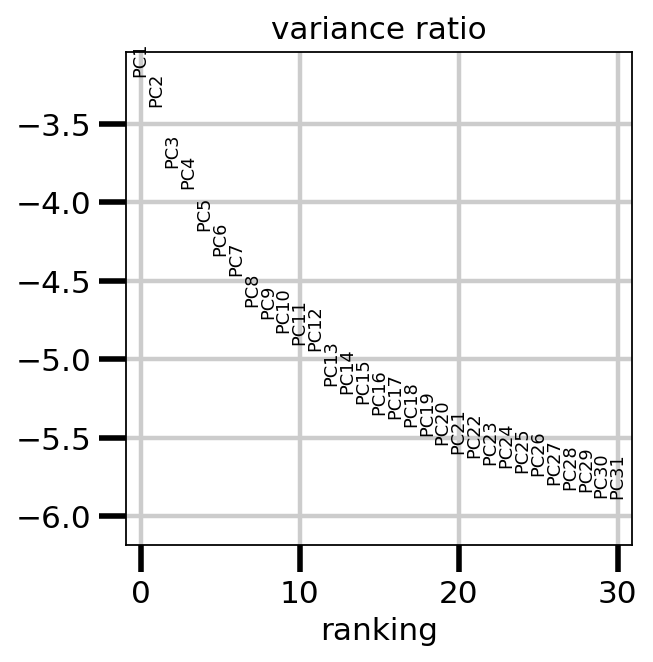

In [16]:
# Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.
sc.tl.pca(adata, use_highly_variable=True, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)

## RUN Neighbors and UMAP

In [17]:
# fewer neighbors
sc.pp.neighbors(adata, n_neighbors=10, n_pcs = 20)
sc.tl.umap(adata)

computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


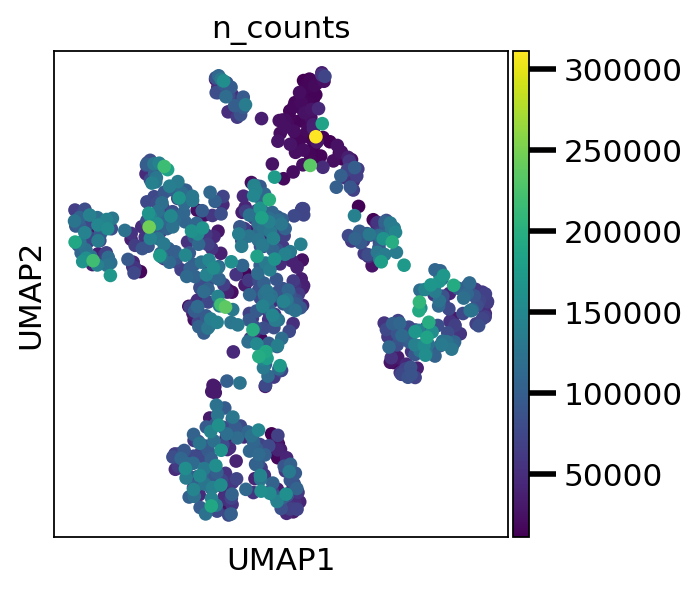

In [18]:
sc.pl.umap(adata, color='n_counts', use_raw=False)

## Cluster

In [19]:
# Perform clustering
louvain_paramenters = [0.1,0.2,0.3,0.4,0.5,1.0,1.5,2.0]
louvain_names = []
for value in louvain_paramenters:
    louvain_names.append('louvain_r' + str(value))

for value,name in zip(louvain_paramenters,louvain_names):
    sc.tl.louvain(adata, resolution=value, key_added=name)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 3 clusters and added
    'louvain_r0.1', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 6 clusters and added
    'louvain_r0.2', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 7 clusters and added
    'louvain_r0.3', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 8 clusters and added
    'louvain_r0.4', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 8 clusters and added
    'louvain_r0.5', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain"

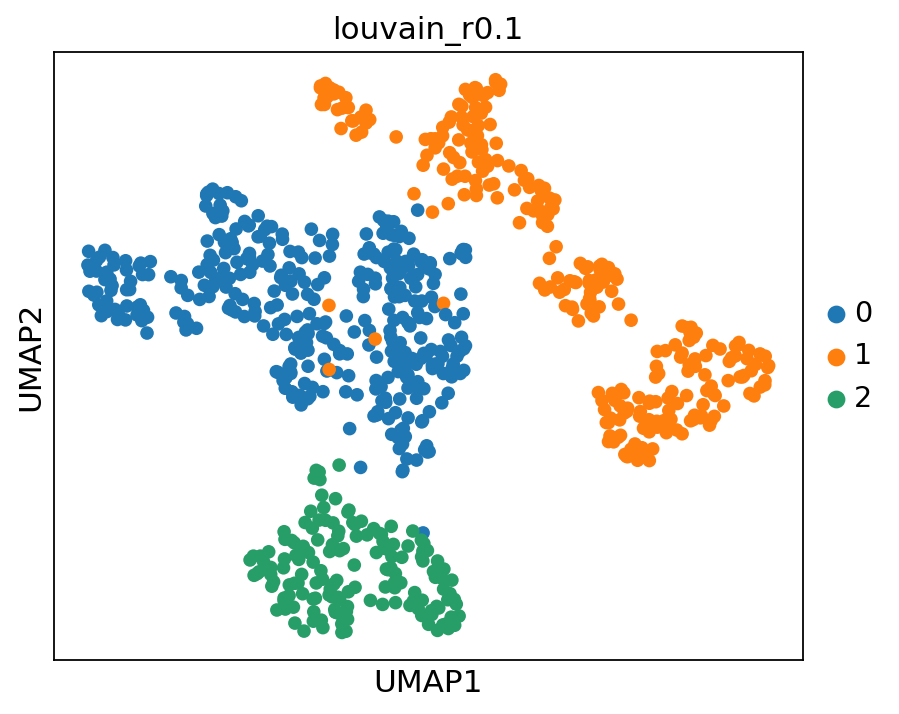

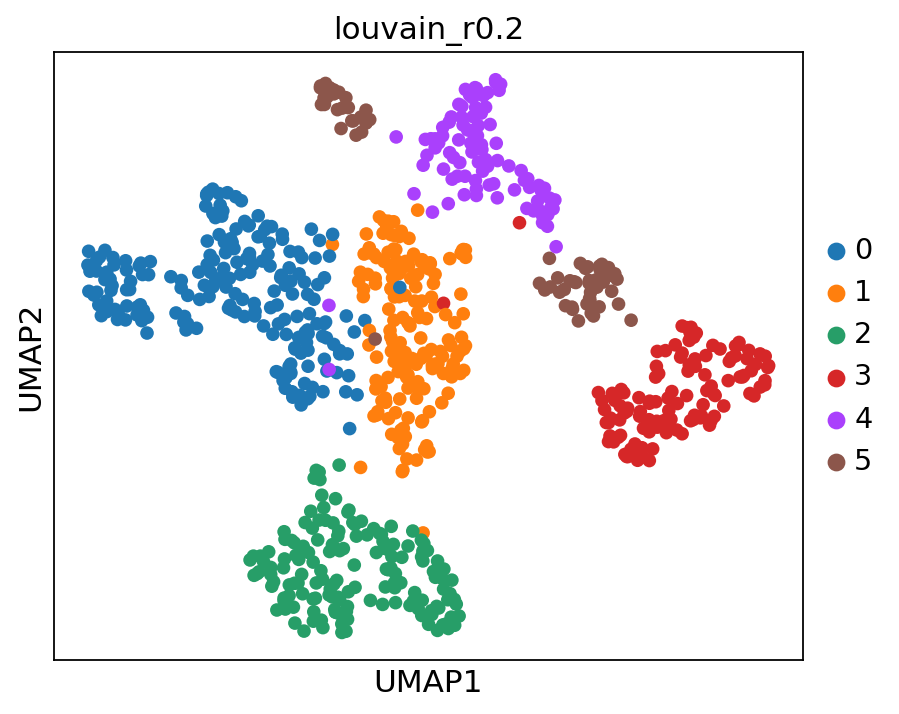

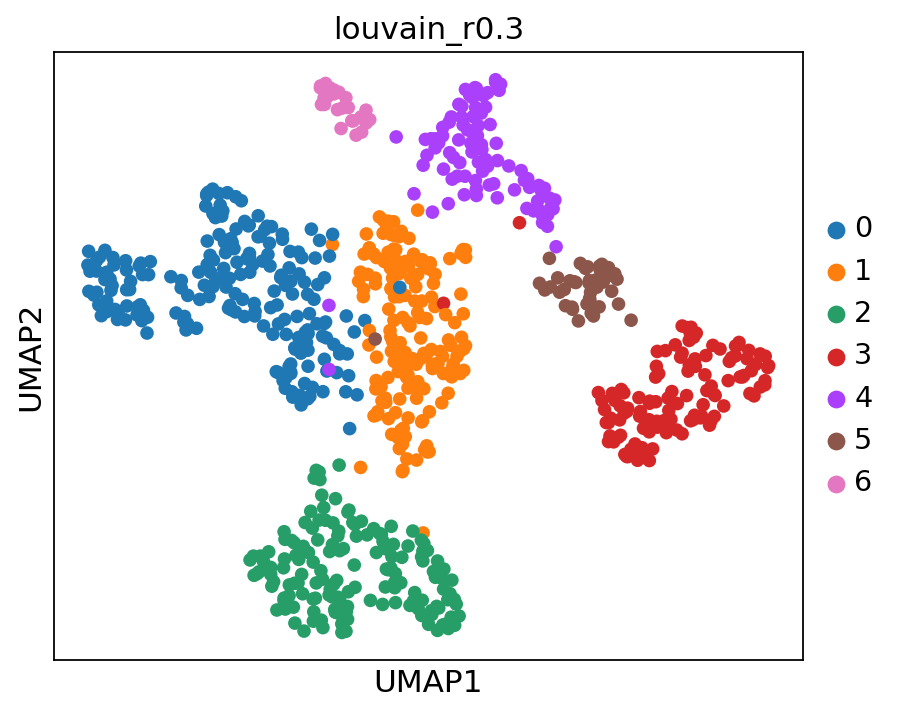

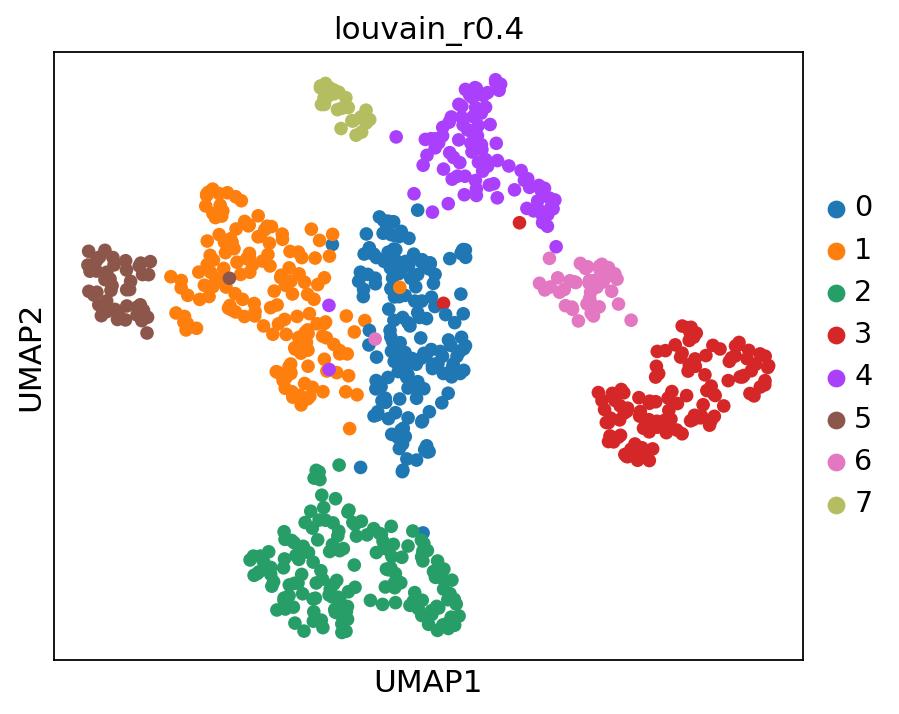

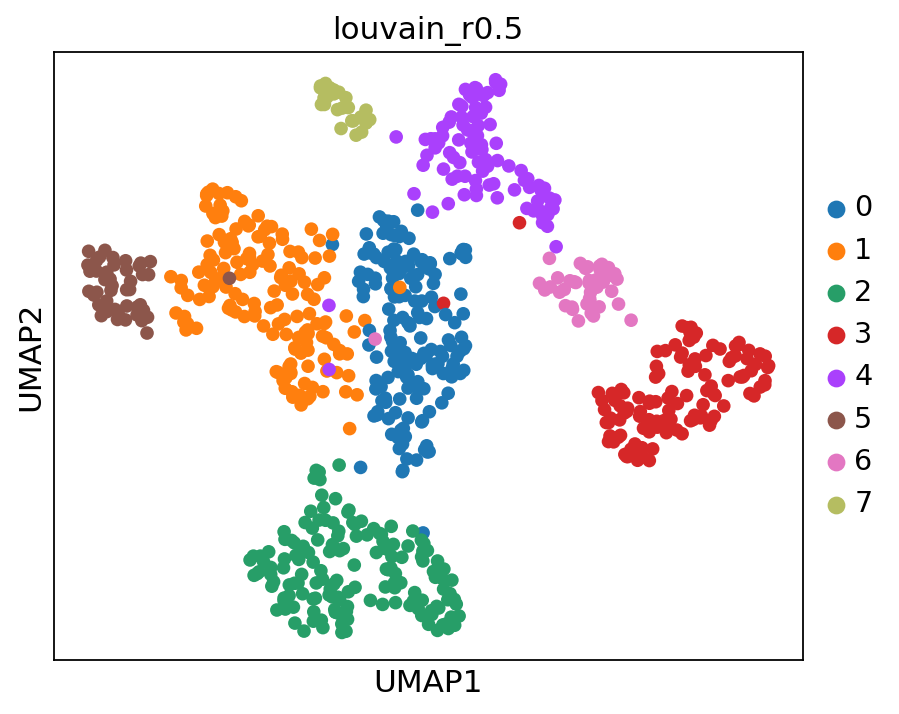

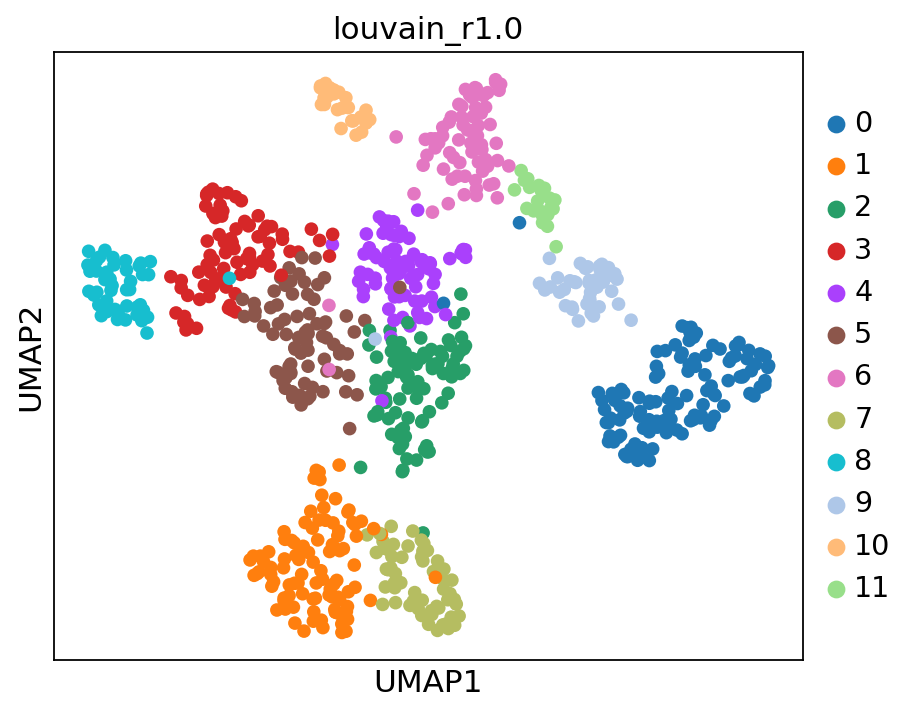

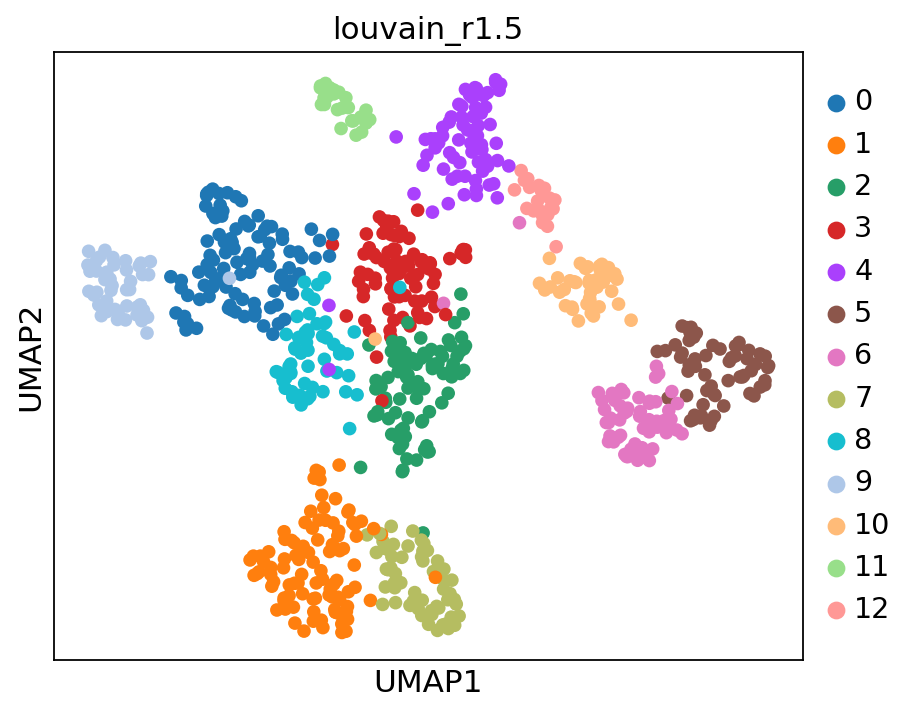

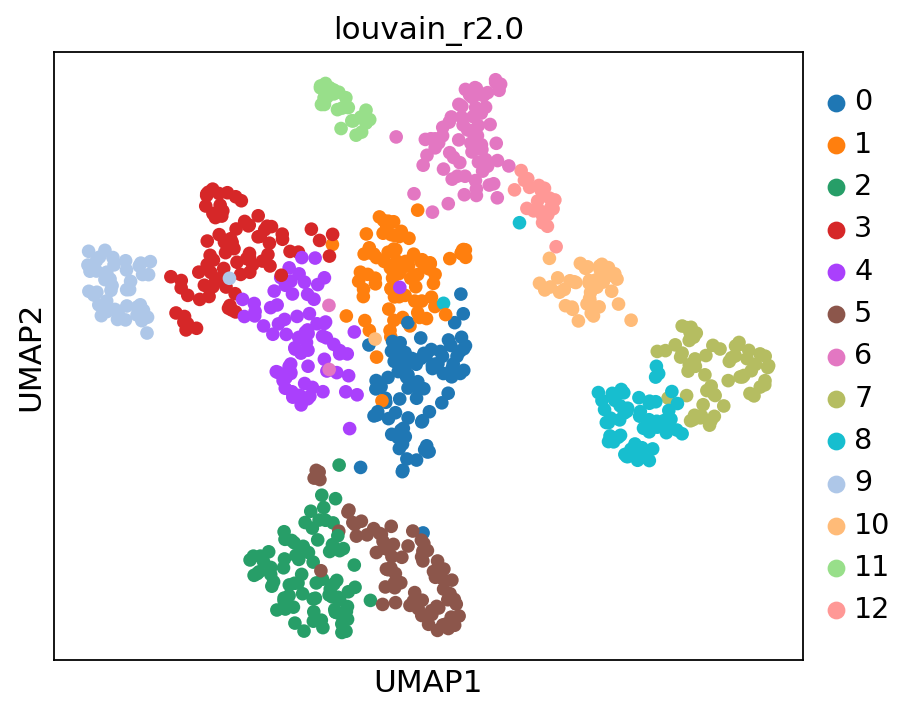

In [20]:
rcParams['figure.figsize']=(6,5)

# Visualize the clustering and how this is reflected by different technical covariates
for name in louvain_names:
    sc.pl.umap(adata, color=[name], use_raw=False)

# sc.pl.umap(adata, color=['louvain_r0.1'], use_raw=False)

In [21]:
# save umap data
adata.write_h5ad(
    os.path.join(output_path, 'ad_only.h5ad')
)

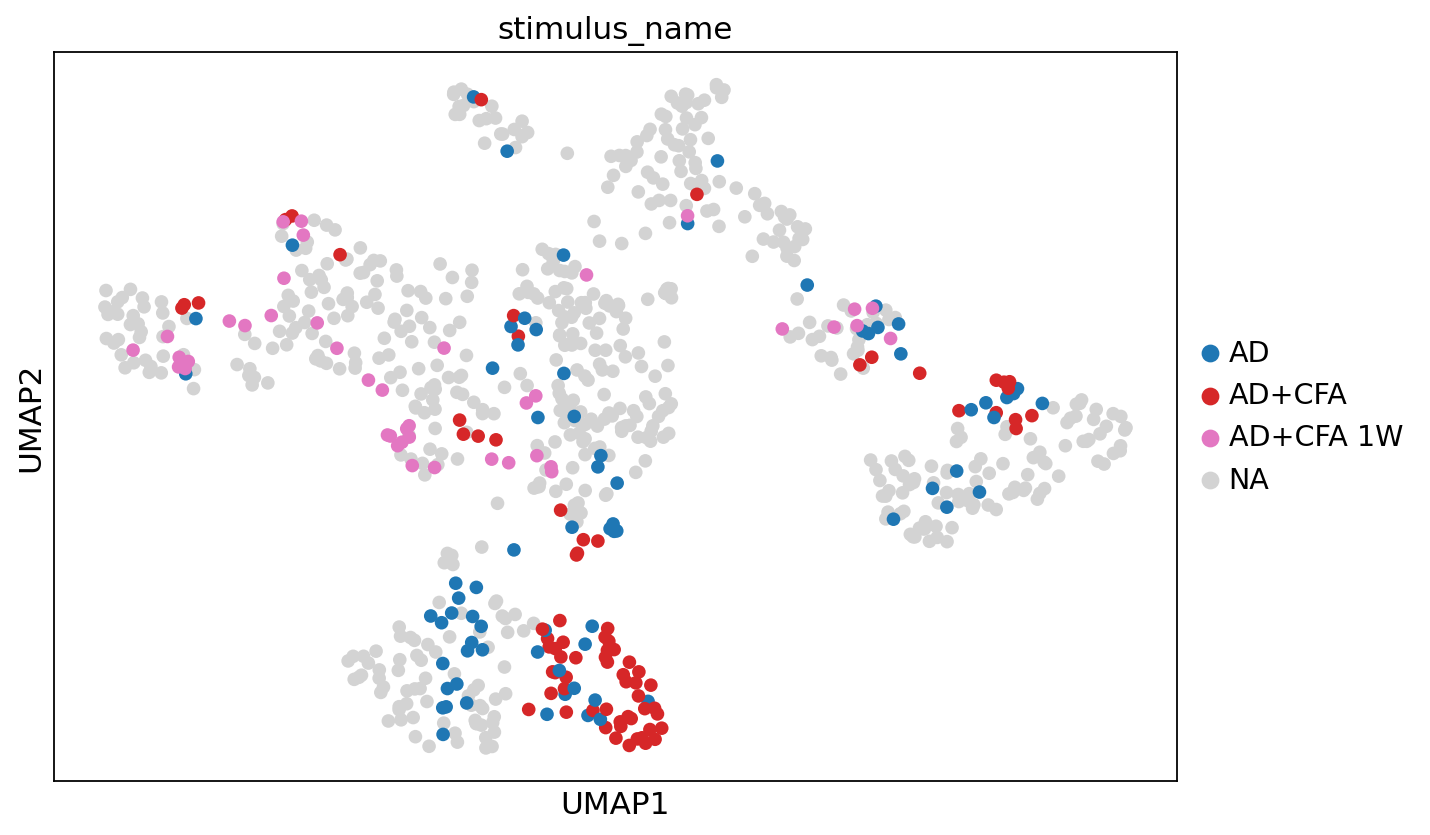

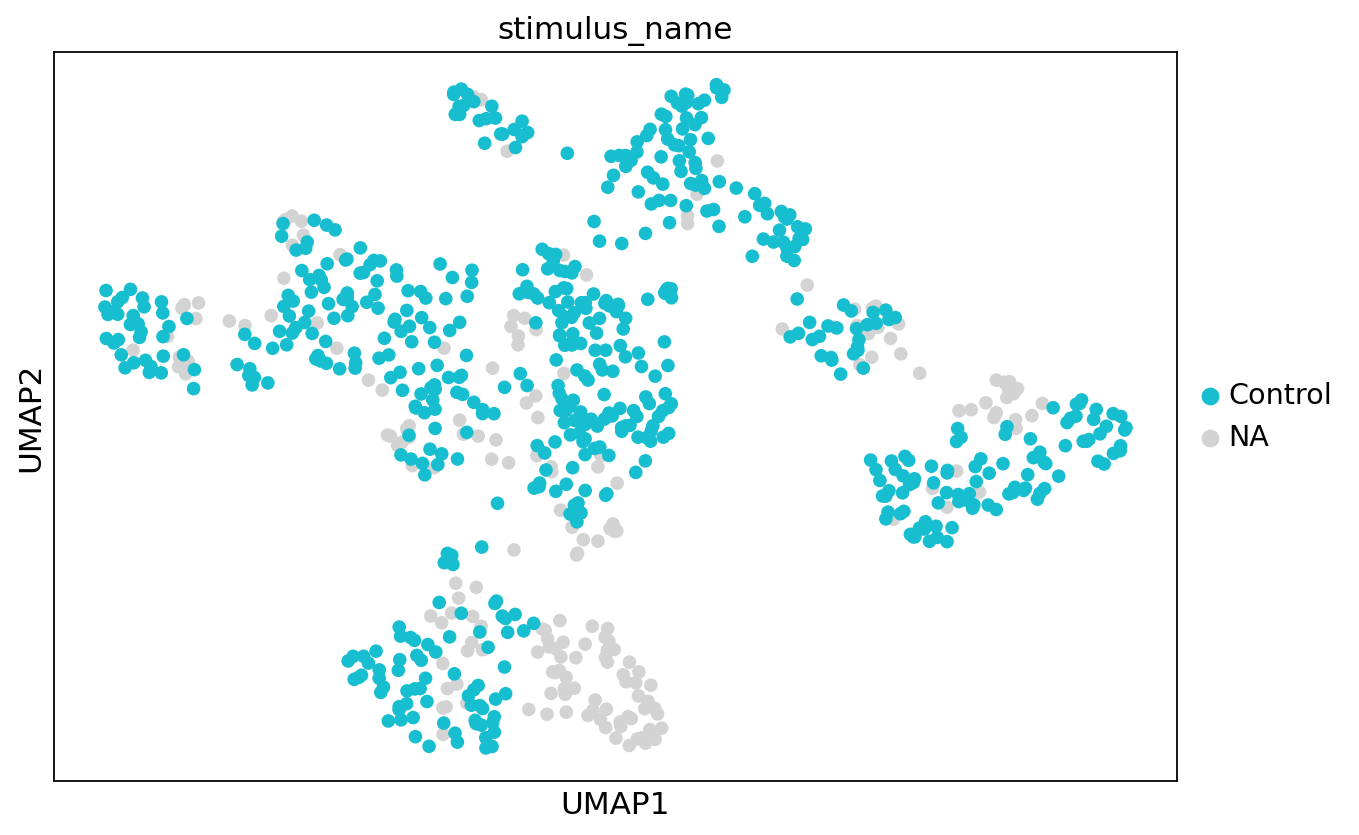

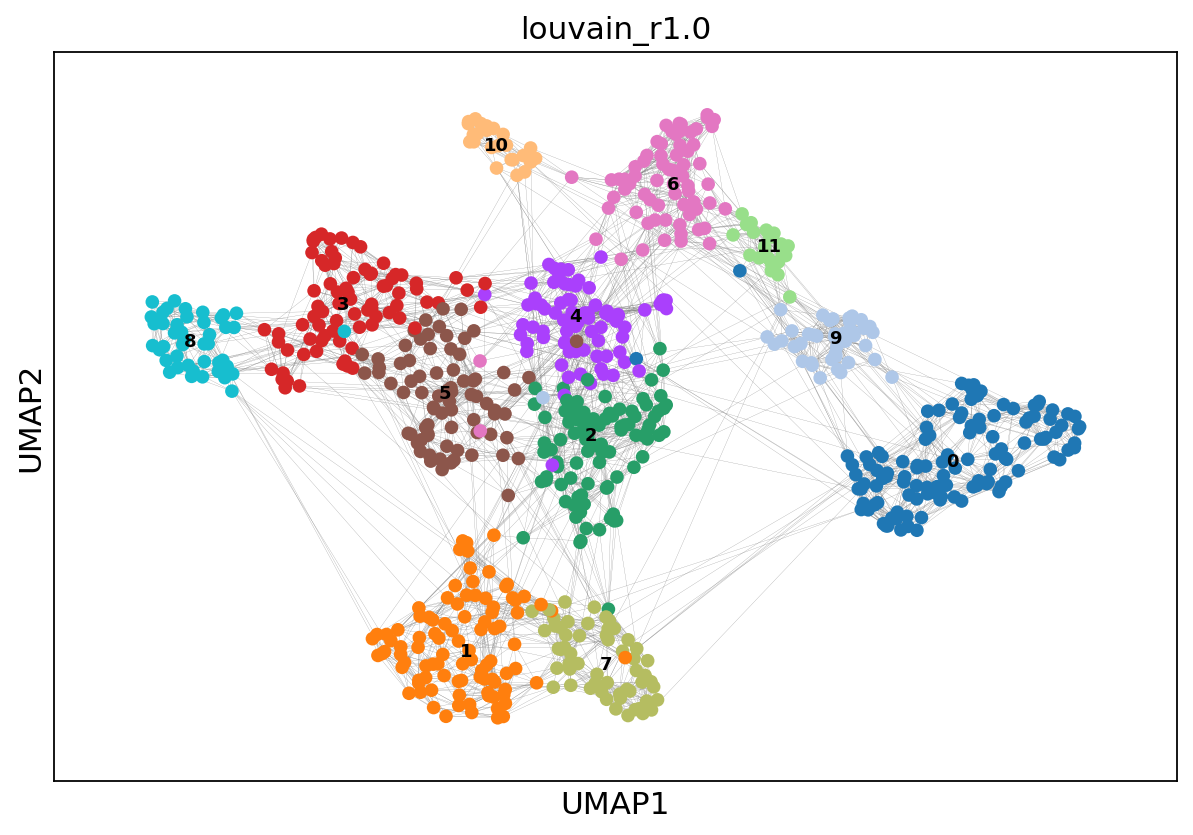

In [22]:
rcParams['figure.figsize']=(9,6)
# select on which louvain you will be doing PAGA
SELECTED_LOUVAIN = 'louvain_r1.0'
sc.pl.umap(adata, color=['stimulus_name'], groups=['AD','AD+CFA','AD+CFA 1W'], palette='tab10',use_raw=False,projection='2d')
sc.pl.umap(adata, color=['stimulus_name'], groups=['Control'], palette='tab10',use_raw=False)
sc.pl.umap(adata, color = [SELECTED_LOUVAIN], projection='2d',legend_loc= 'on data', legend_fontsize= 'xx-small',edges=True) # show selected louvain close to the rest to see clusters better



# PAGA

drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fr', graph_drawing coordinates (adata.obsm) (0:00:00)


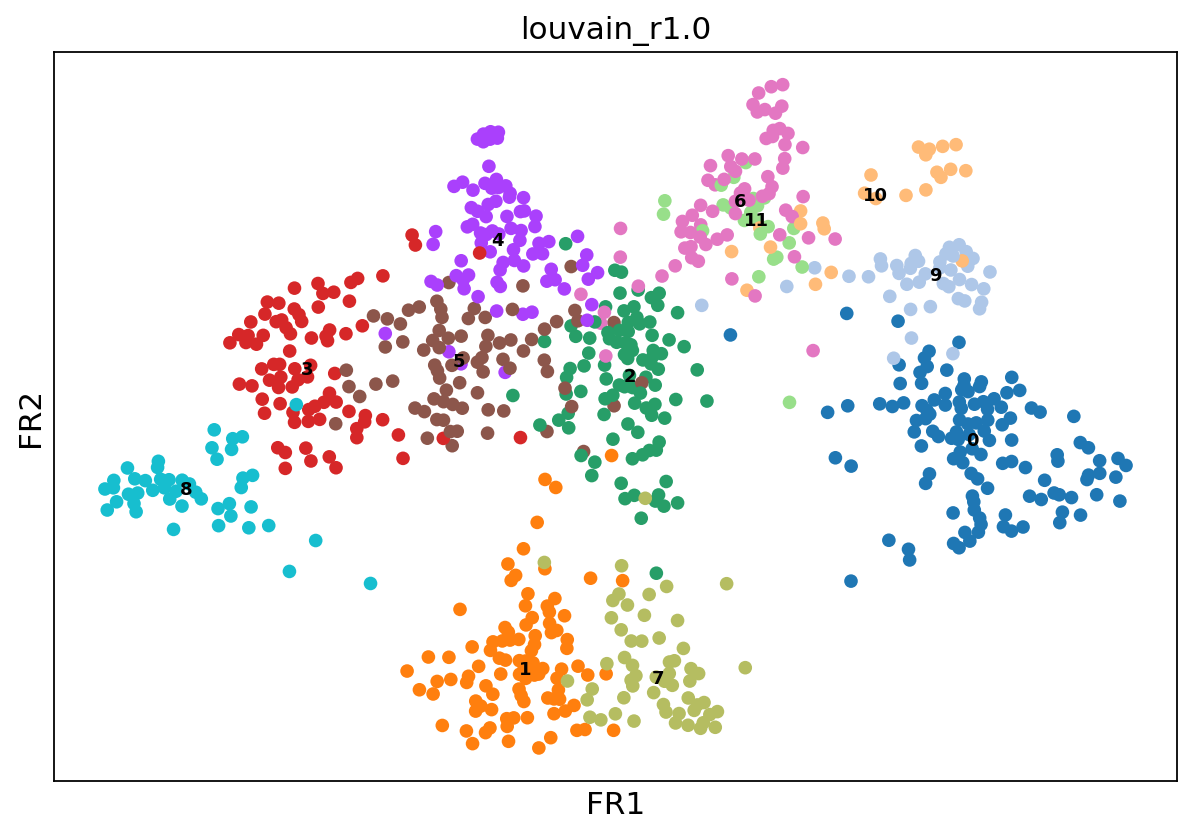

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])


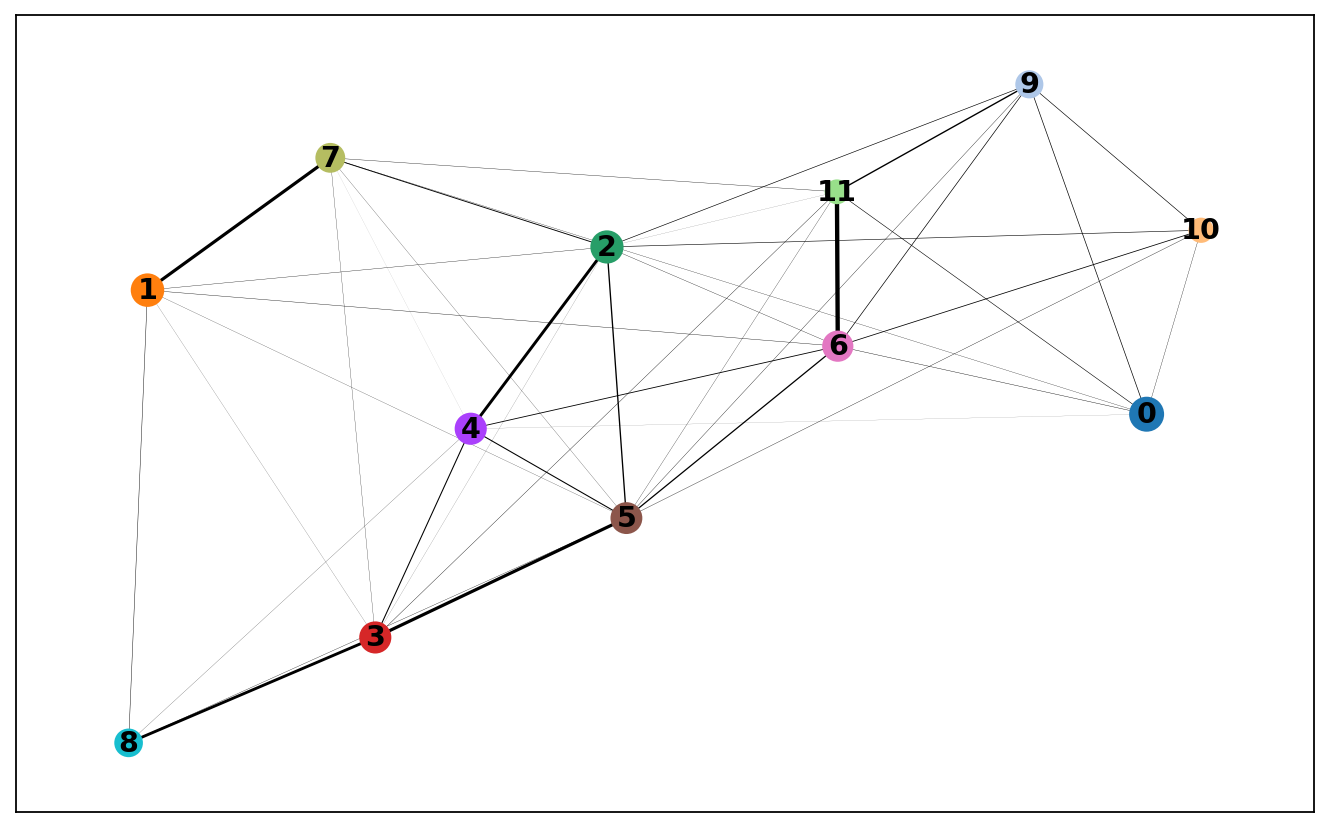

In [23]:
# use the umap to initialize the graph layout.
sc.tl.draw_graph(adata, init_pos='X_umap')
sc.pl.draw_graph(adata, color=SELECTED_LOUVAIN, legend_loc='on data', legend_fontsize = 'xx-small')
sc.tl.paga(adata, groups=SELECTED_LOUVAIN)
sc.pl.paga(adata, color=SELECTED_LOUVAIN, edge_width_scale = 0.3)

In [24]:
# We can now redraw the graph using another starting position from the paga layout. The following is just as well possible for a UMAP.
sc.tl.draw_graph(adata, init_pos='paga')

drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fr', graph_drawing coordinates (adata.obsm) (0:00:00)


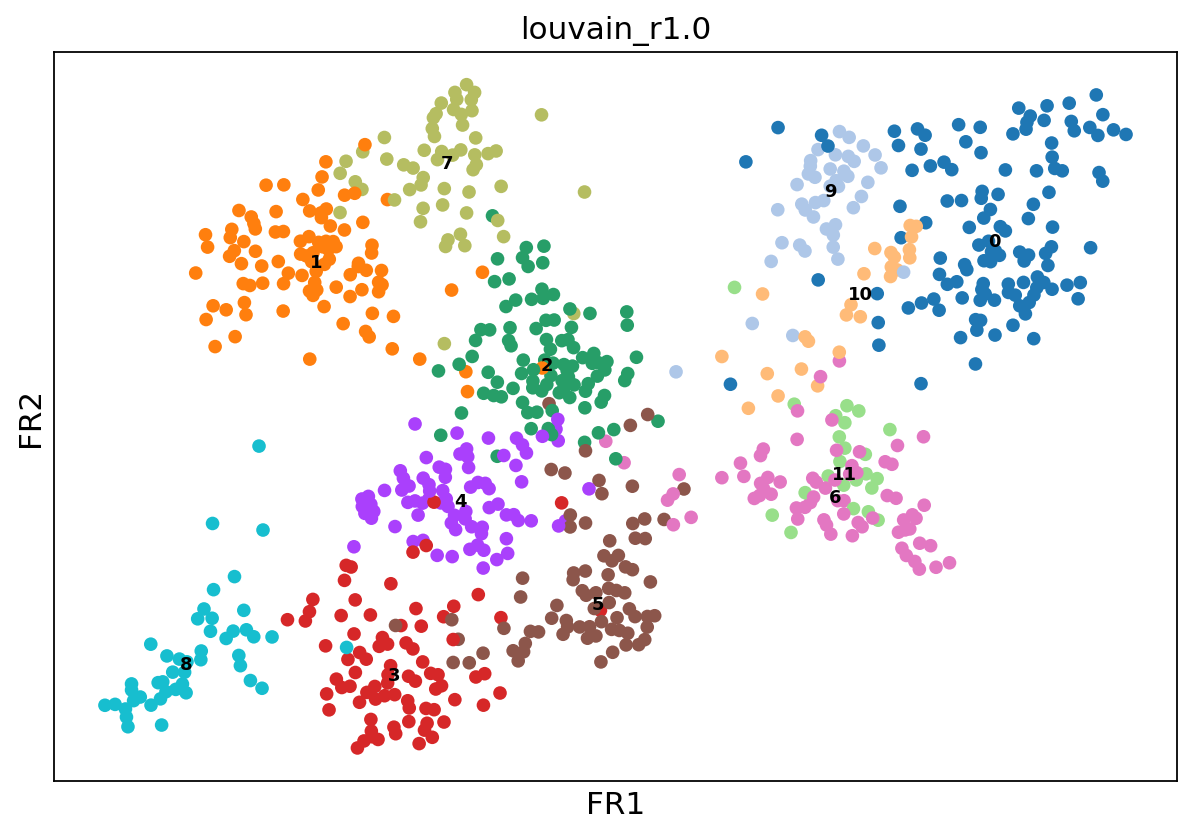

In [25]:
sc.pl.draw_graph(adata, color=[SELECTED_LOUVAIN], legend_loc='on data', legend_fontsize=  'xx-small')

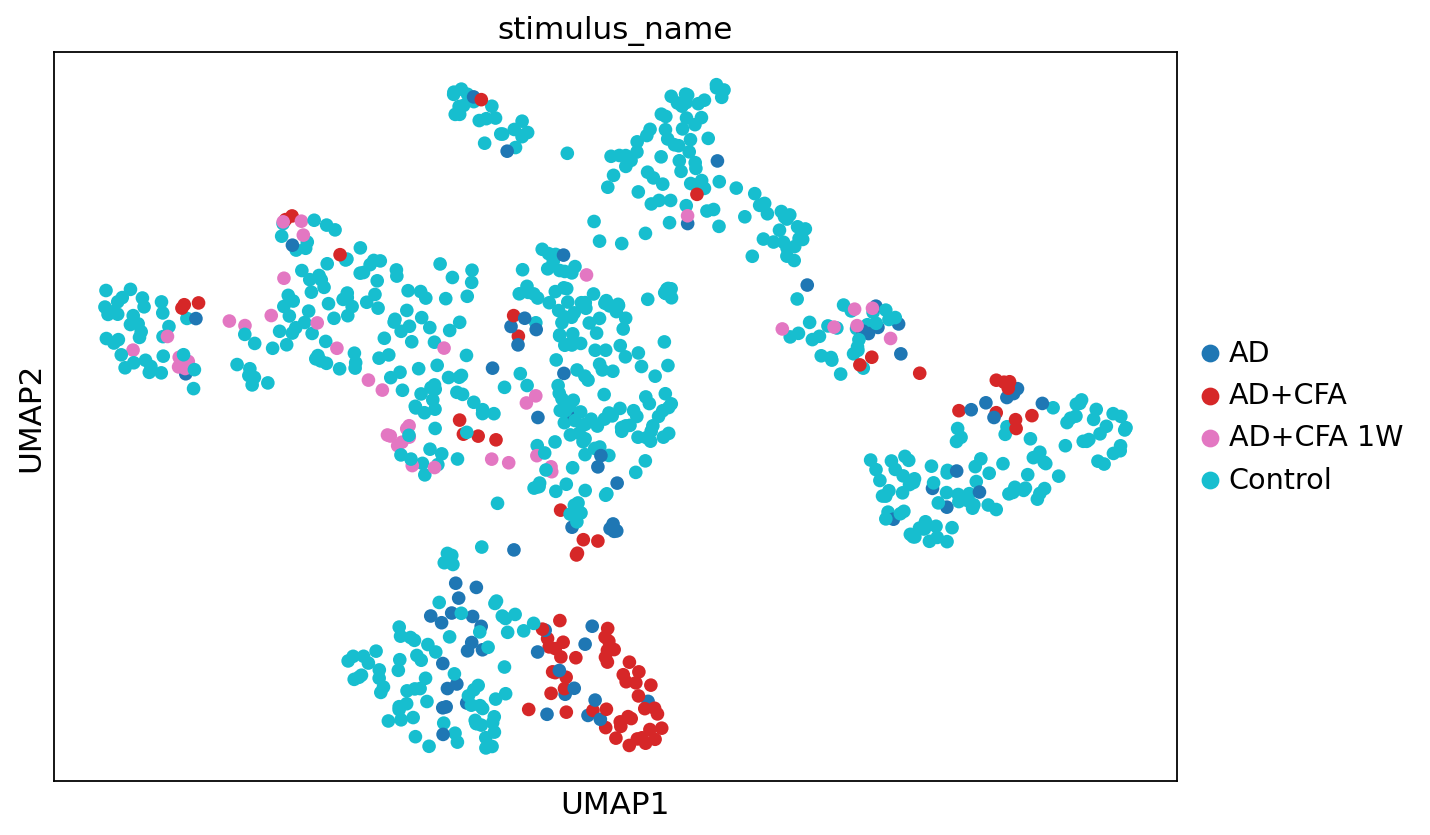

--> added 'pos', the PAGA positions (adata.uns['paga'])


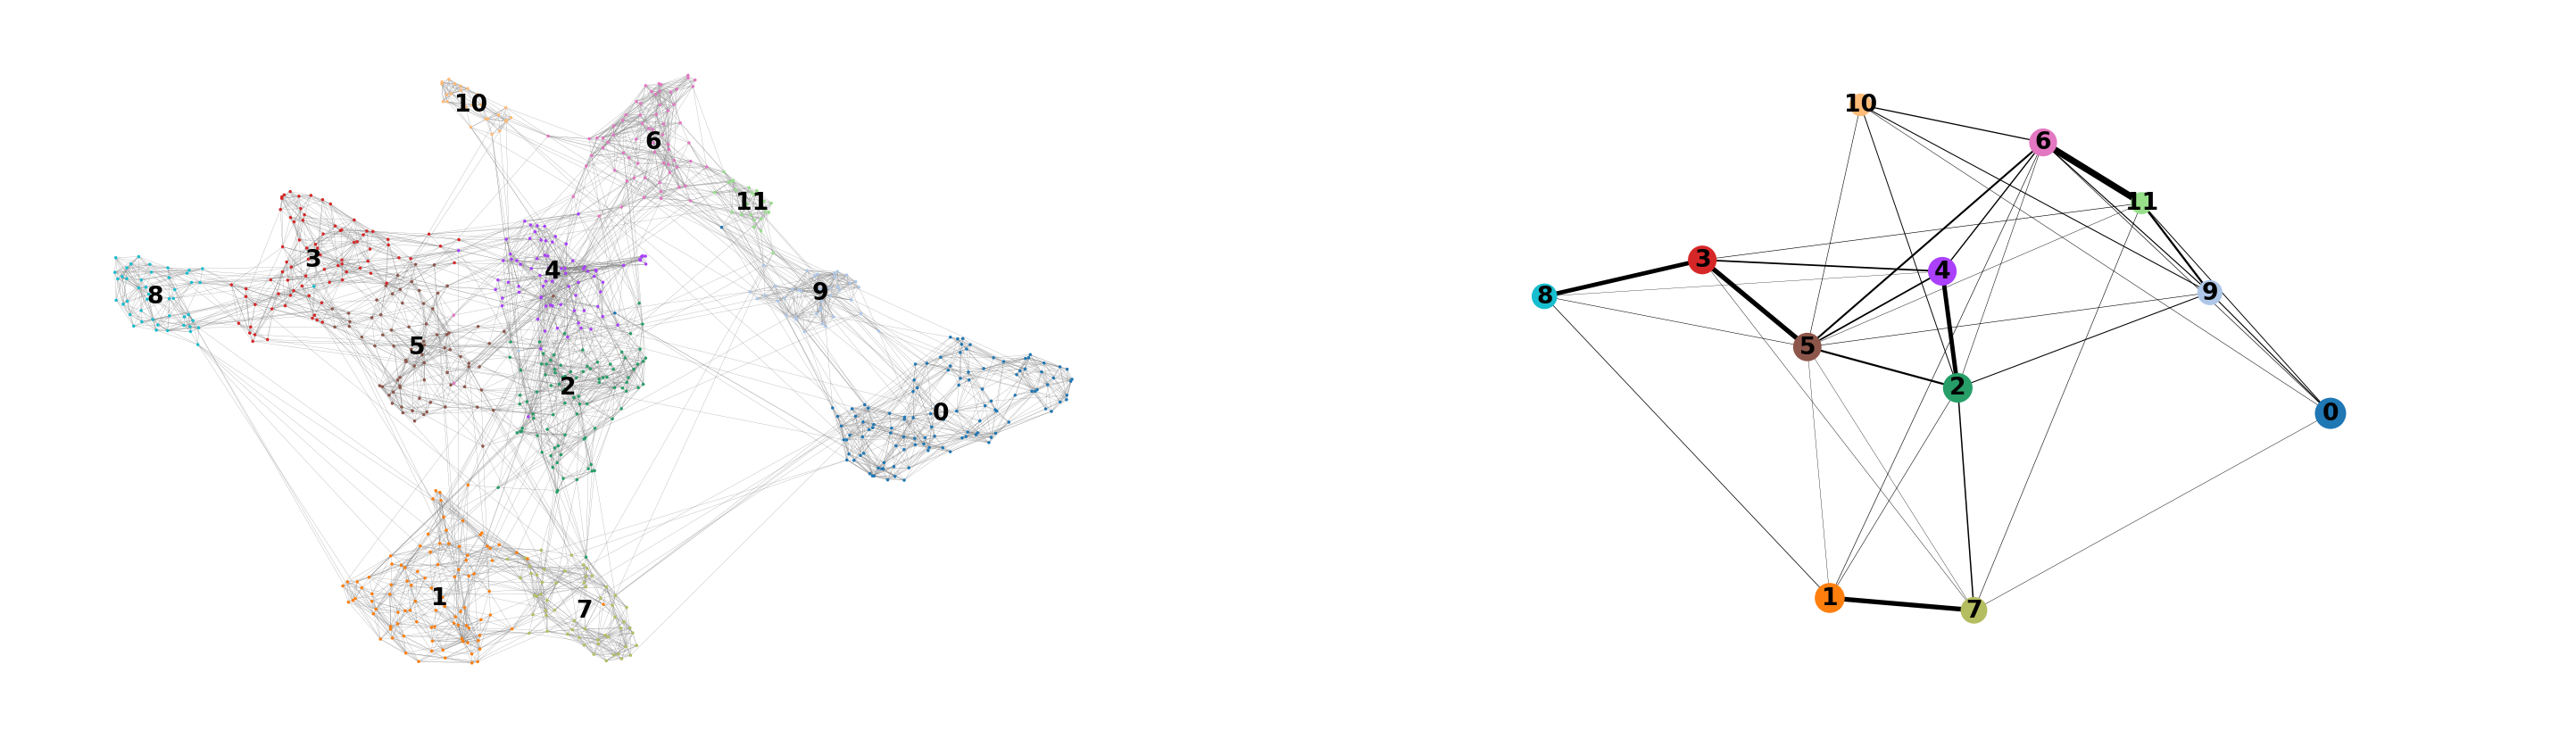

In [26]:
# Show stimuli and pseudotime predictions
sc.pl.umap(adata, color=['stimulus_name'], groups=['AD','AD+CFA','AD+CFA 1W','Control'], use_raw=False)
sc.pl.paga_compare(
    adata, threshold=0.03, title='', right_margin=0.2, size=10, edge_width_scale=0.5,
    legend_fontsize=12, fontsize=12, frameon=False, edges=True)

In [27]:
# Choose a root cell for diffusion pseudotime. 
# cluster 0 a "root cell" of pseudotime?
adata.uns['iroot'] = np.flatnonzero(adata.obs[SELECTED_LOUVAIN]  == '8')[0]

sc.tl.dpt(adata)

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.98573637 0.9789662  0.9734342  0.9697389  0.9642013
     0.9555421  0.95096874 0.943211   0.94116443 0.93941426 0.93371046
     0.932869   0.91906625 0.90379906]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)
computing Diffusion Pseudotime using n_dcs=10
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)


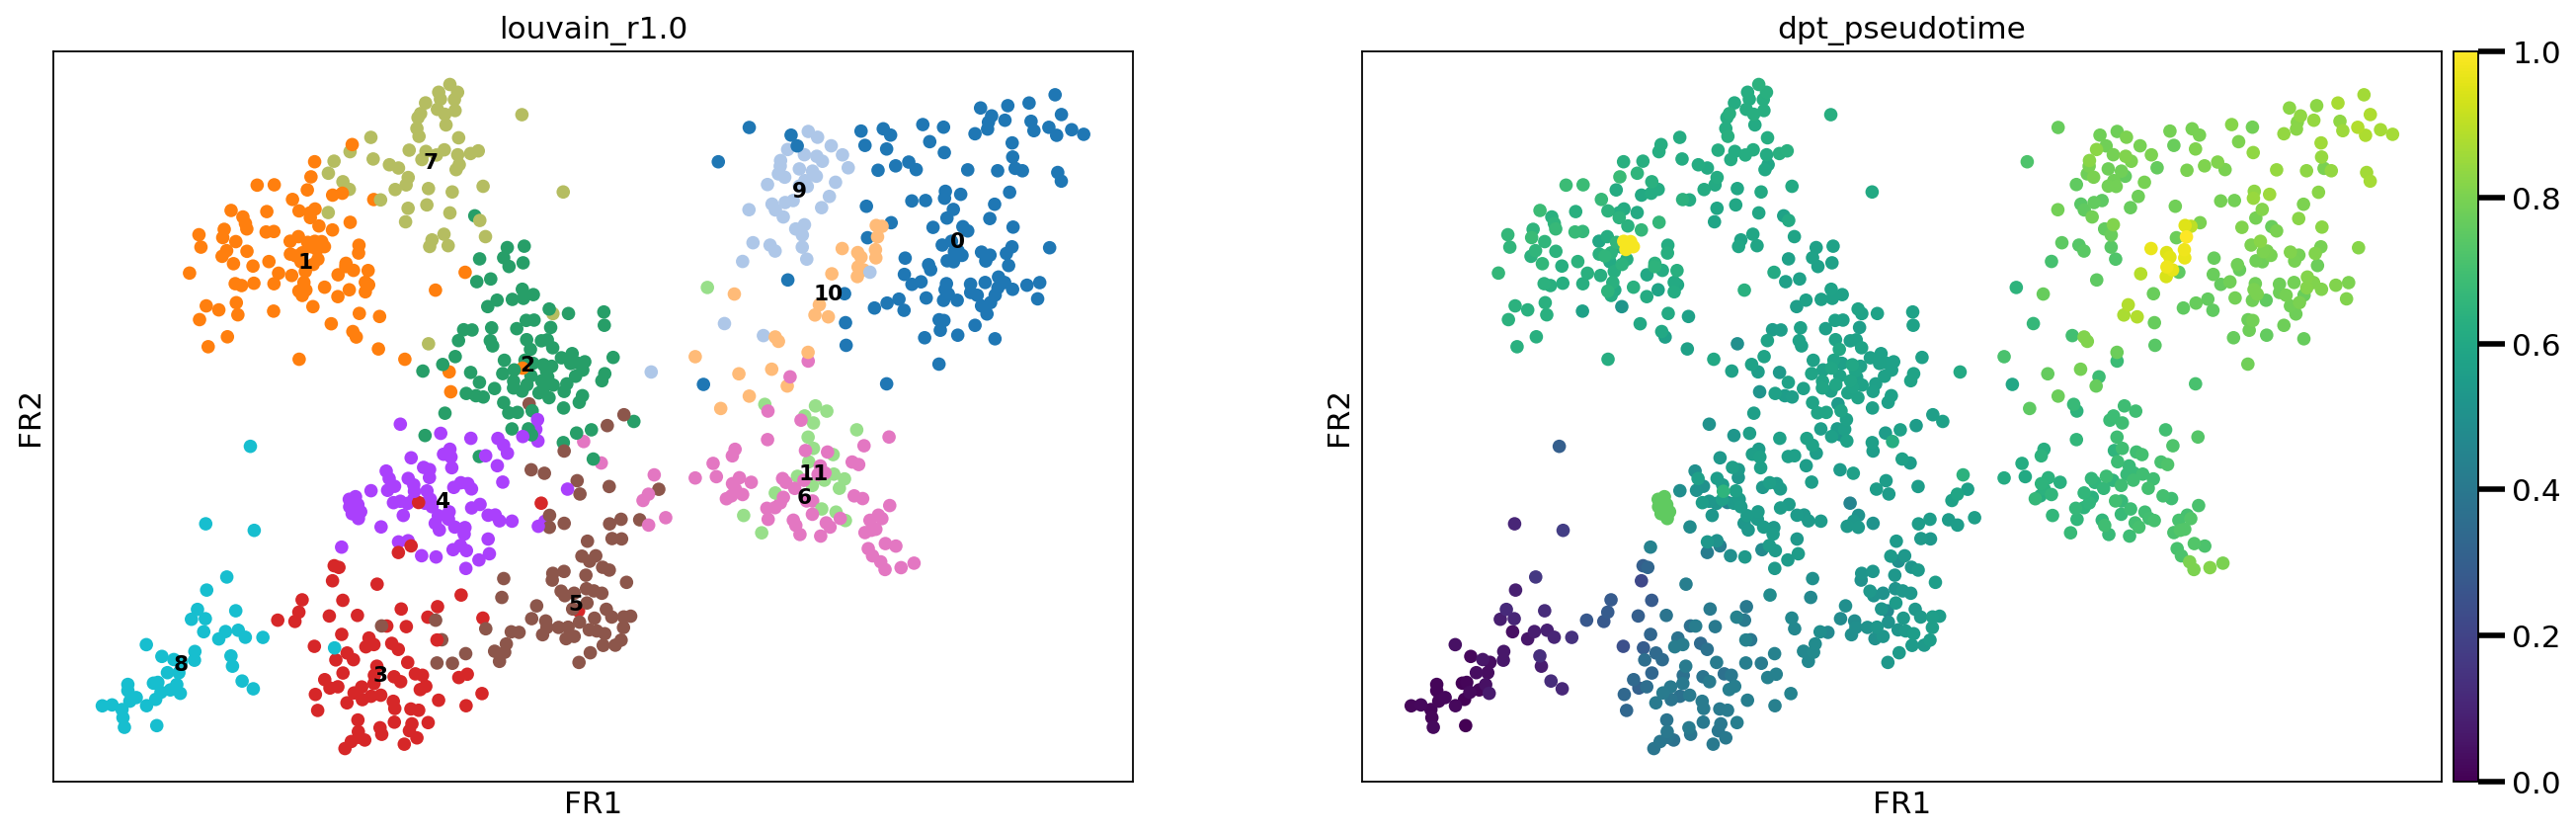

In [28]:
sc.pl.draw_graph(adata, color=[SELECTED_LOUVAIN, 'dpt_pseudotime'], legend_loc='on data', legend_fontsize= 'x-small')

## Subset to a few clusters

In [29]:
# select only controls and AD stimuli 
# On louvain 0.3, clusters 2,3 ... could be analyzed separately
adata_sub = adata[np.where((adata.obs[SELECTED_LOUVAIN] =="1" ) |
                            (adata.obs[SELECTED_LOUVAIN] =="7" ) |
                            (adata.obs[SELECTED_LOUVAIN] =="2") |
                            (adata.obs[SELECTED_LOUVAIN] =="3") |
                            (adata.obs[SELECTED_LOUVAIN] =="5") 
                                    )]

In [30]:
adata_sub

View of AnnData object with n_obs × n_vars = 399 × 16000
    obs: 'sample', 'stimulus', 'red', 'green', 'well_id', 'plate_number', 'batch', 'stimulus_name', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'n_genes', 'to_exclude', 'plate_str', 'louvain_r0.5', 'louvain_r1', 'louvain_r1.5', 'louvain_r2', 'louvain_r2.5', 'louvain_r0.1', 'louvain_r0.2', 'louvain_r0.3', 'louvain_r0.4', 'louvain_r1.0', 'louvain_r2.0', 'dpt_pseudotime'
    var: 'gene_id', 'gene_name', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'louvain', 'louvain_r1_colors', 'louvain_r2.5_colors', 'louvain_r2_colors', 'neighbors', 'pca', 'plate_str_colors', 'sample_colors', 'stimulus_name_colors', 'umap', 'louvain_r0.1_colors', 'louvain_r0.2_colors', 'louvain_r0.3_colors', 'louvain_r0.4_colors', 'louvain_r1.0_colors', 'louvain_r2.0_colors',

In [31]:
adata_sub = adata_sub.raw.to_adata() # on the raw data bedause I need to scale again to the smaller dataset (it is already nromalized and log transformed)

In [32]:
adata_sub


AnnData object with n_obs × n_vars = 399 × 21764
    obs: 'sample', 'stimulus', 'red', 'green', 'well_id', 'plate_number', 'batch', 'stimulus_name', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'n_genes', 'to_exclude', 'plate_str', 'louvain_r0.5', 'louvain_r1', 'louvain_r1.5', 'louvain_r2', 'louvain_r2.5', 'louvain_r0.1', 'louvain_r0.2', 'louvain_r0.3', 'louvain_r0.4', 'louvain_r1.0', 'louvain_r2.0', 'dpt_pseudotime'
    var: 'gene_id', 'gene_name', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'hvg', 'log1p', 'louvain', 'louvain_r1_colors', 'louvain_r2.5_colors', 'louvain_r2_colors', 'neighbors', 'pca', 'plate_str_colors', 'sample_colors', 'stimulus_name_colors', 'umap', 'louvain_r0.1_colors', 'louvain_r0.2_colors', 'louvain_r0.3_colors', 'louvain_r0.4_colors', 'louvain_r1.0_colors', 'louvain_r2.0_colors', 'draw_graph', 'paga', 'louvain_r1.0_sizes', 'iroot', 'diffmap_evals'
    obsm: 'X_pca

In [33]:
# check how many cells in each stim
adata_sub.obs['stimulus_name'].value_counts()

Control      271
AD+CFA        59
AD            43
AD+CFA 1W     26
Name: stimulus_name, dtype: int64

normalizing counts per cell
    finished (0:00:00)


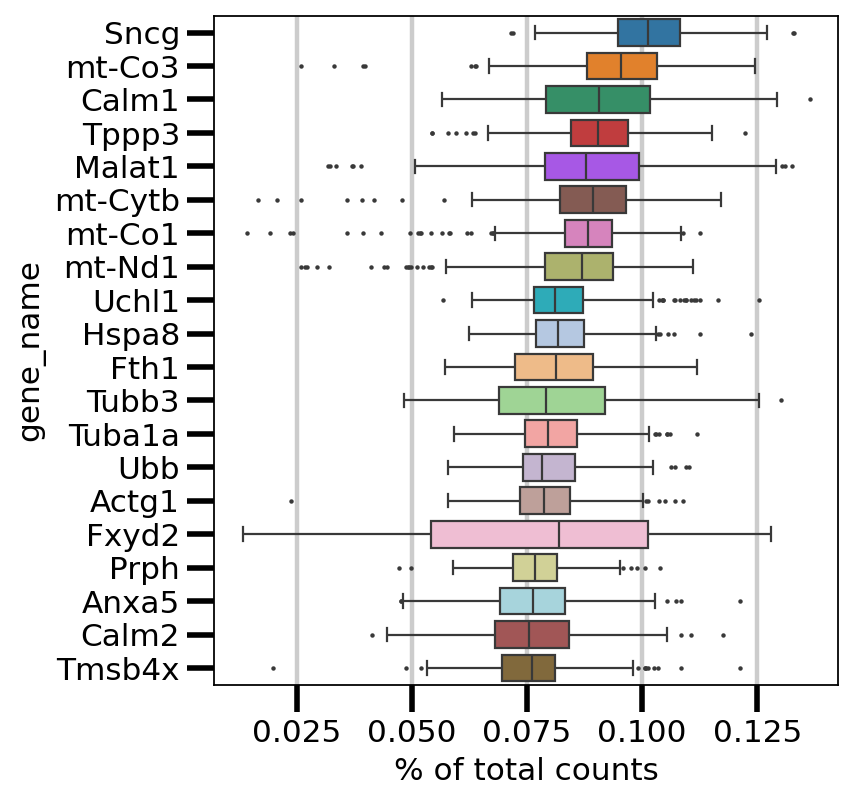

In [34]:
sc.pl.highest_expr_genes(adata_sub, n_top=20)

In [35]:
# save all normalized and log transformed in raw slot.
adata_sub.raw = adata_sub

In [36]:
# select only highly variable genes
sc.pp.highly_variable_genes(adata_sub, flavor='cell_ranger', n_top_genes=HOW_MANY_HIGHLY_VARIABLE_GENES) # kan add batch-key; better do that per batch

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


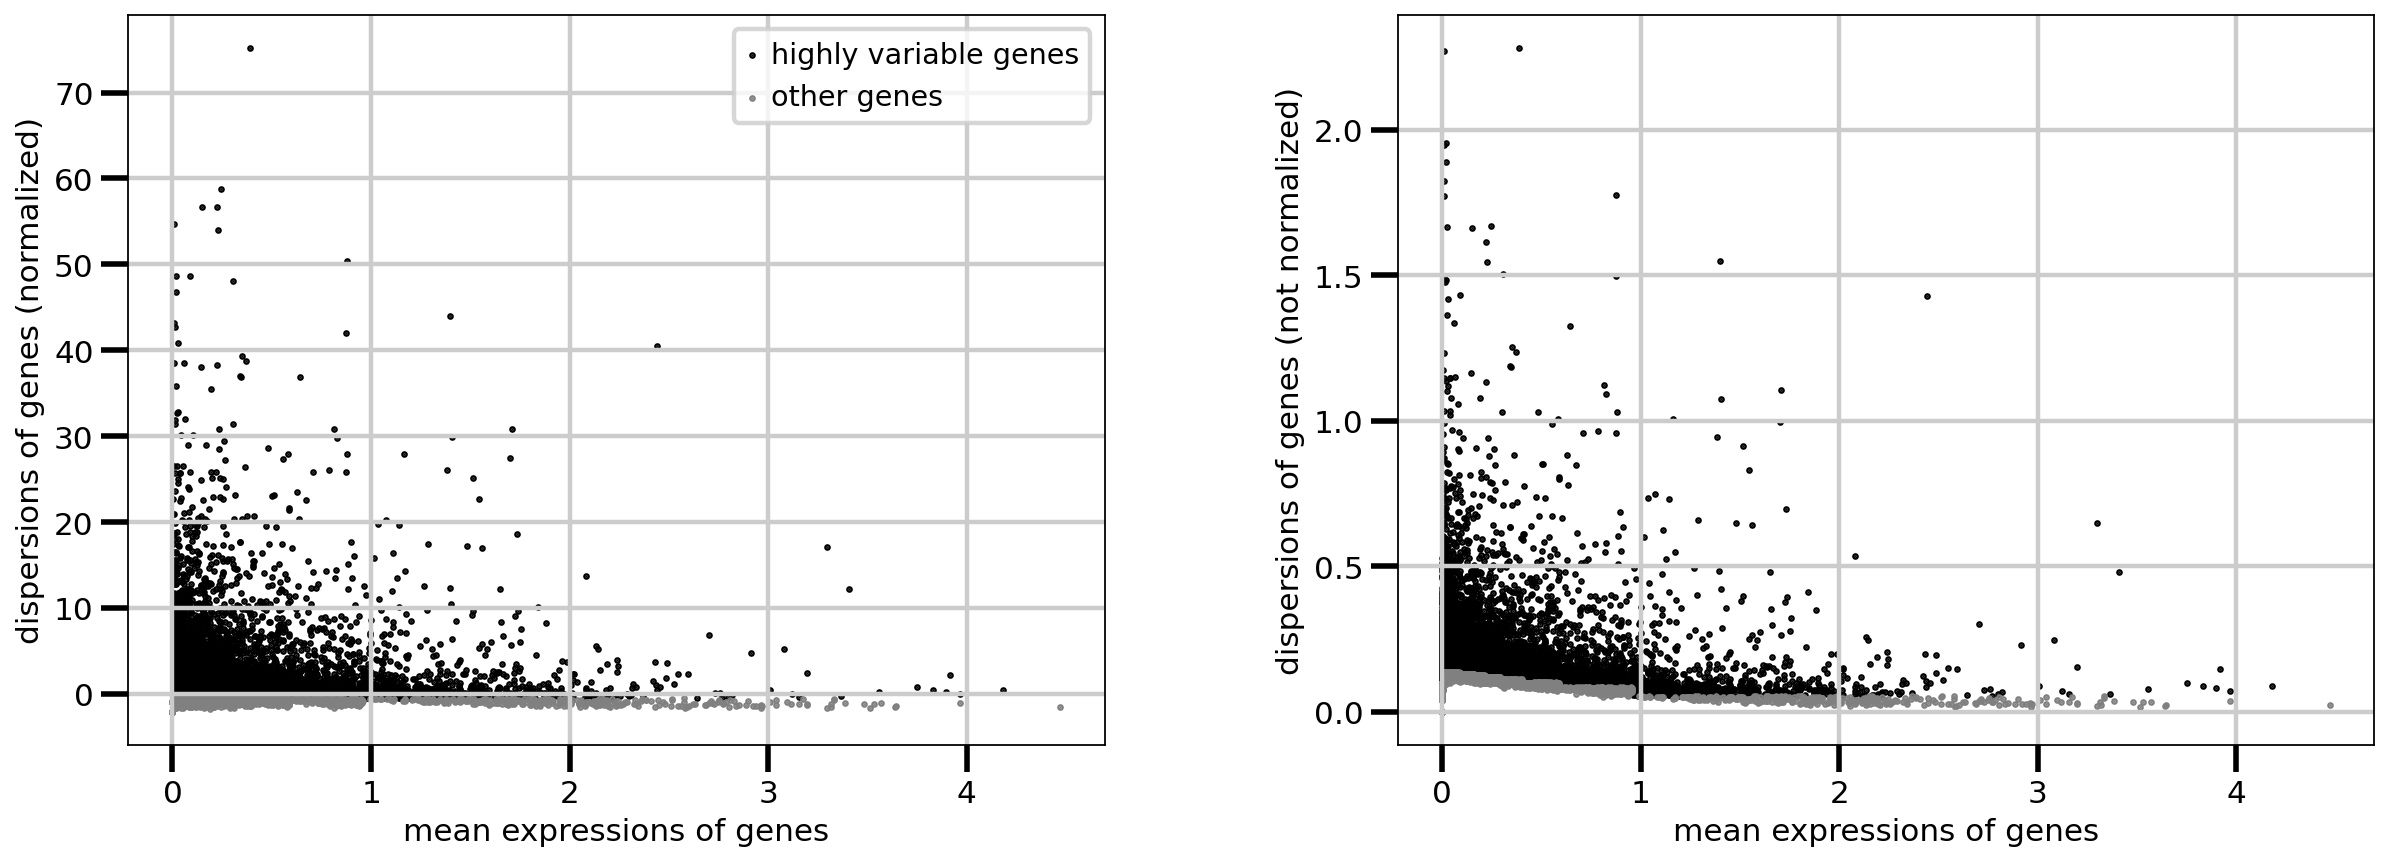

In [37]:
sc.pl.highly_variable_genes(adata_sub)

In [38]:
adata_sub = adata_sub[:, adata_sub.var.highly_variable] # select and keep only those high variable genes

In [39]:
adata_sub

View of AnnData object with n_obs × n_vars = 399 × 16000
    obs: 'sample', 'stimulus', 'red', 'green', 'well_id', 'plate_number', 'batch', 'stimulus_name', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'n_genes', 'to_exclude', 'plate_str', 'louvain_r0.5', 'louvain_r1', 'louvain_r1.5', 'louvain_r2', 'louvain_r2.5', 'louvain_r0.1', 'louvain_r0.2', 'louvain_r0.3', 'louvain_r0.4', 'louvain_r1.0', 'louvain_r2.0', 'dpt_pseudotime'
    var: 'gene_id', 'gene_name', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'louvain', 'louvain_r1_colors', 'louvain_r2.5_colors', 'louvain_r2_colors', 'neighbors', 'pca', 'plate_str_colors', 'sample_colors', 'stimulus_name_colors', 'umap', 'louvain_r0.1_colors', 'louvain_r0.2_colors', 'louvain_r0.3_colors', 'louvain_r0.4_colors', 'louvain_r1.0_colors', 'louvain_r2.0_colors', 'draw_graph', 

In [40]:
sc.pp.regress_out(adata_sub, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata_sub, max_value=10)

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:14)


computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)


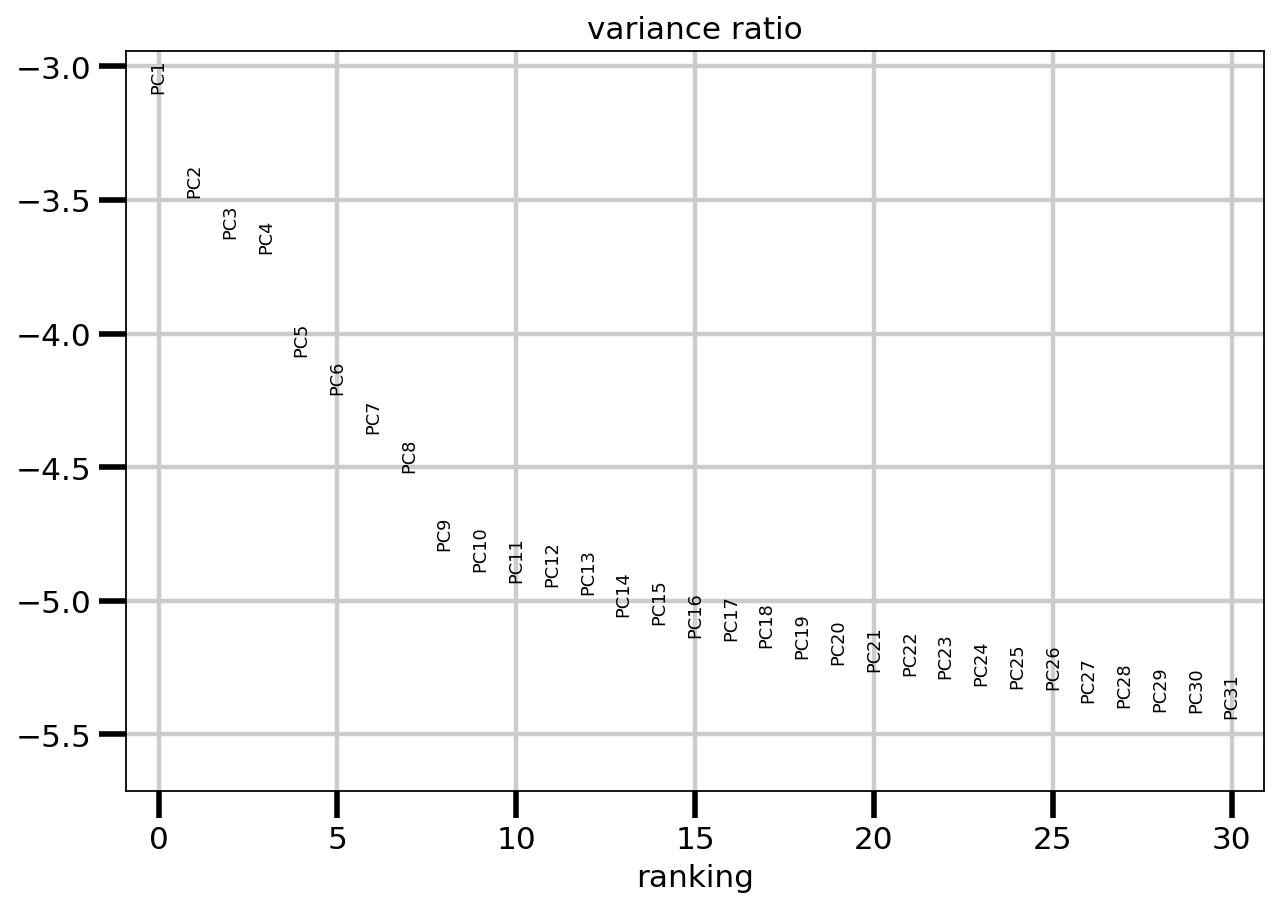

In [41]:
# Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.
sc.tl.pca(adata_sub, use_highly_variable=True, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata_sub, log=True)

In [42]:
# fewer neighbors
sc.pp.neighbors(adata_sub, n_neighbors=5, n_pcs = 15)
sc.tl.umap(adata_sub)

computing neighbors
    using 'X_pca' with n_pcs = 15
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:00)


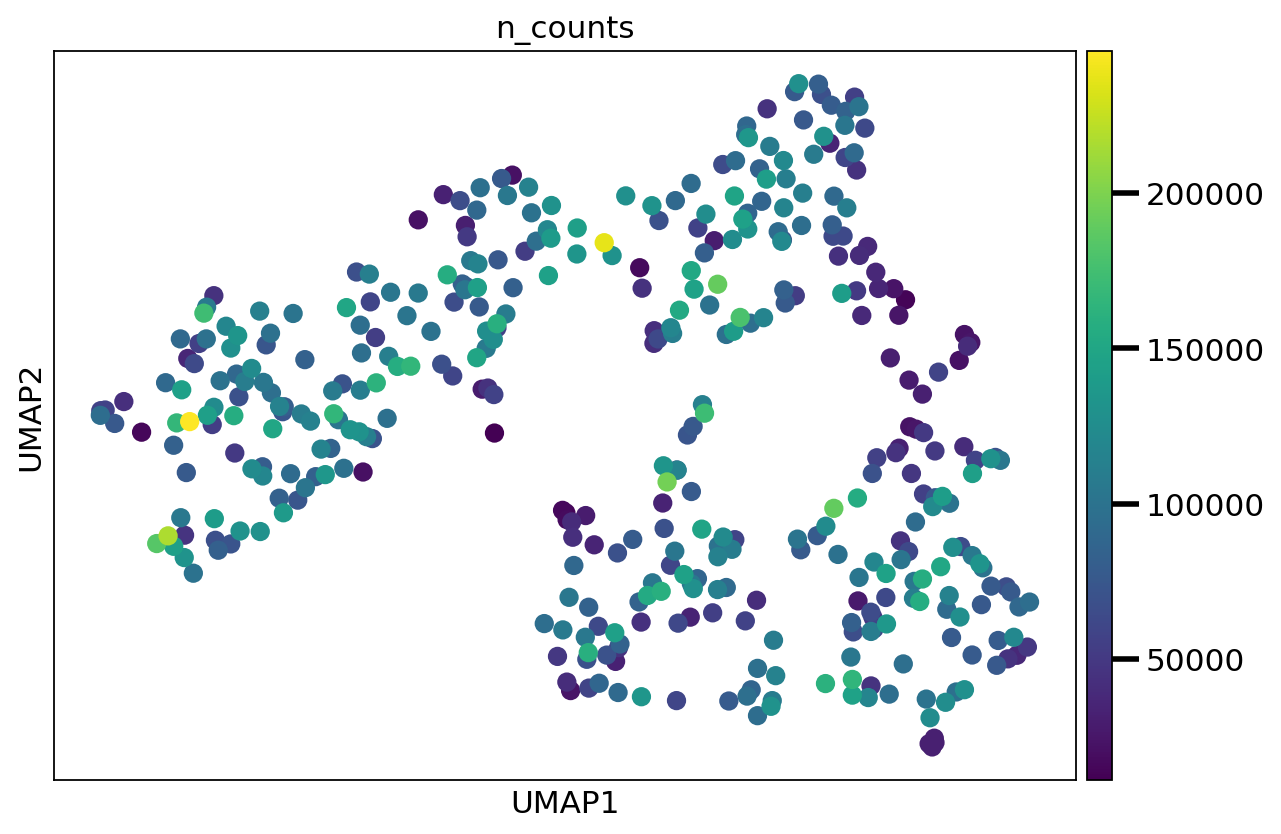

In [43]:
sc.pl.umap(adata_sub, color='n_counts', use_raw=False)

In [44]:
# Perform clustering - using highly variable genes
louvain_paramenters = [0.1,0.2,0.3,0.4,0.5,1.0]
louvain_names = []
for value in louvain_paramenters:
    louvain_names.append('louvain_r' + str(value))

for value,name in zip(louvain_paramenters,louvain_names):
    sc.tl.louvain(adata_sub, resolution=value, key_added=name)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 3 clusters and added
    'louvain_r0.1', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 5 clusters and added
    'louvain_r0.2', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 5 clusters and added
    'louvain_r0.3', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 6 clusters and added
    'louvain_r0.4', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 7 clusters and added
    'louvain_r0.5', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain"

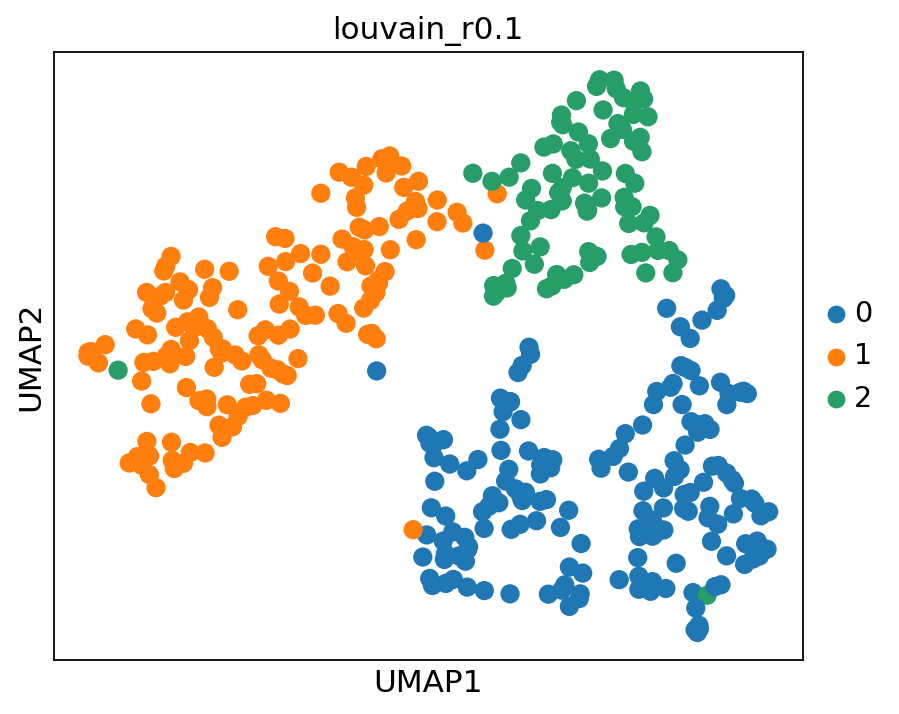

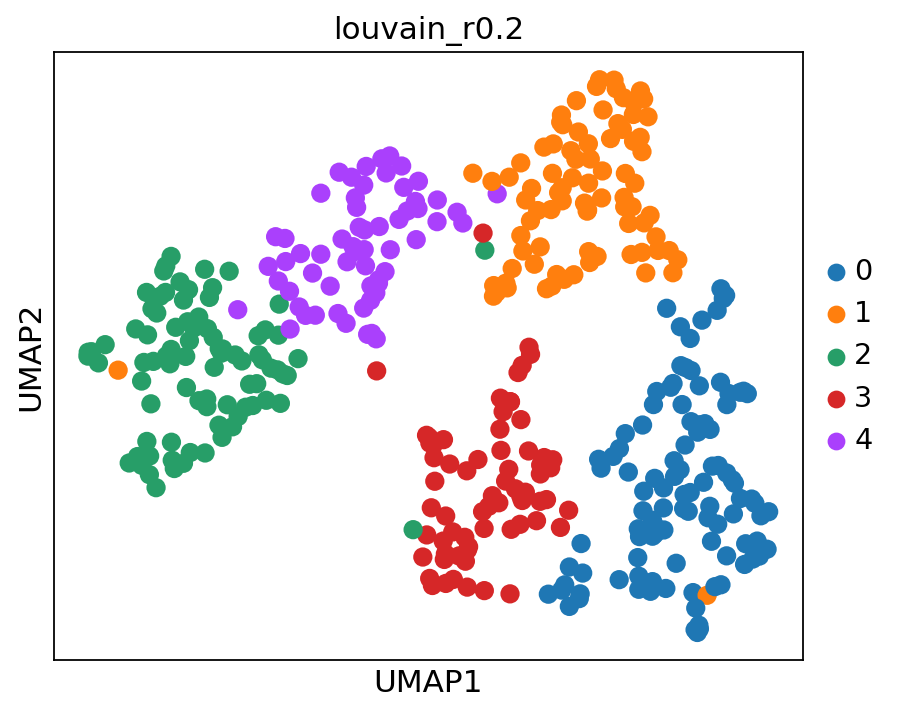

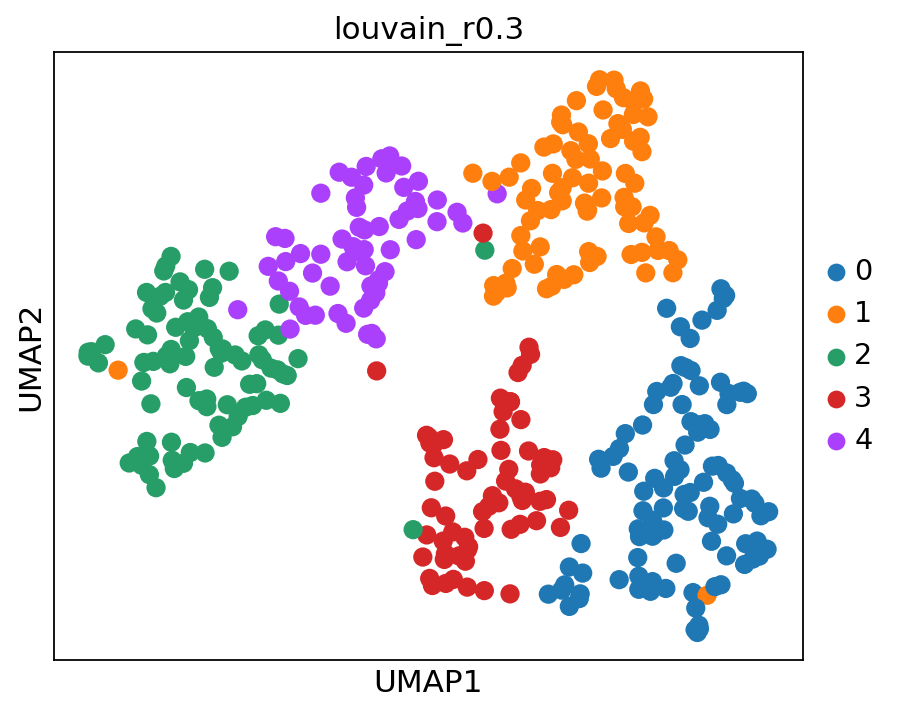

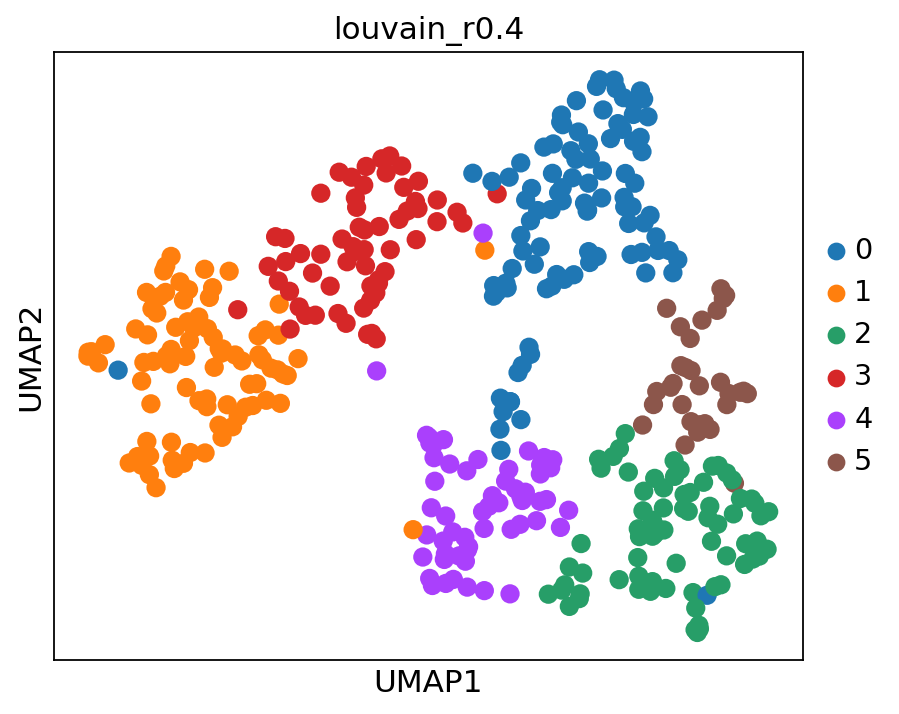

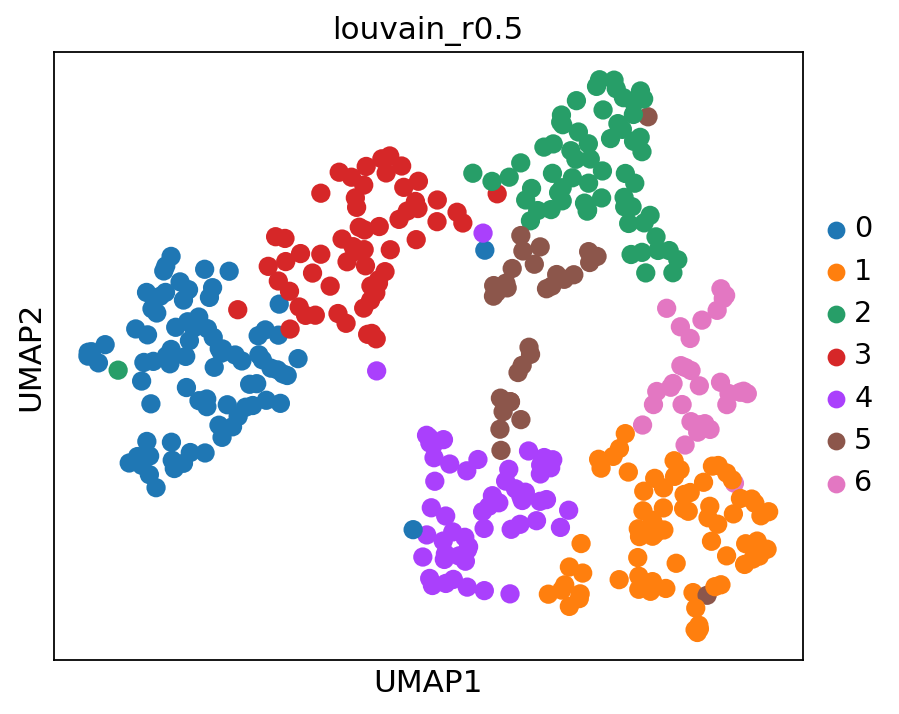

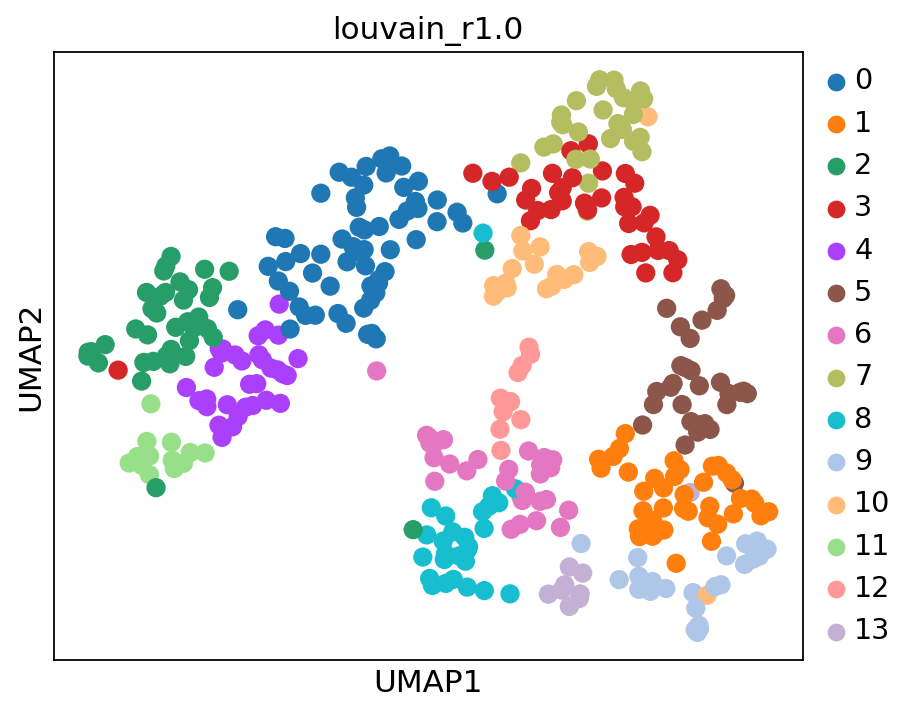

In [45]:
rcParams['figure.figsize']=(6,5)

# Visualize the clustering and how this is reflected by different technical covariates
for name in louvain_names:
    sc.pl.umap(adata_sub, color=[name], use_raw=False)


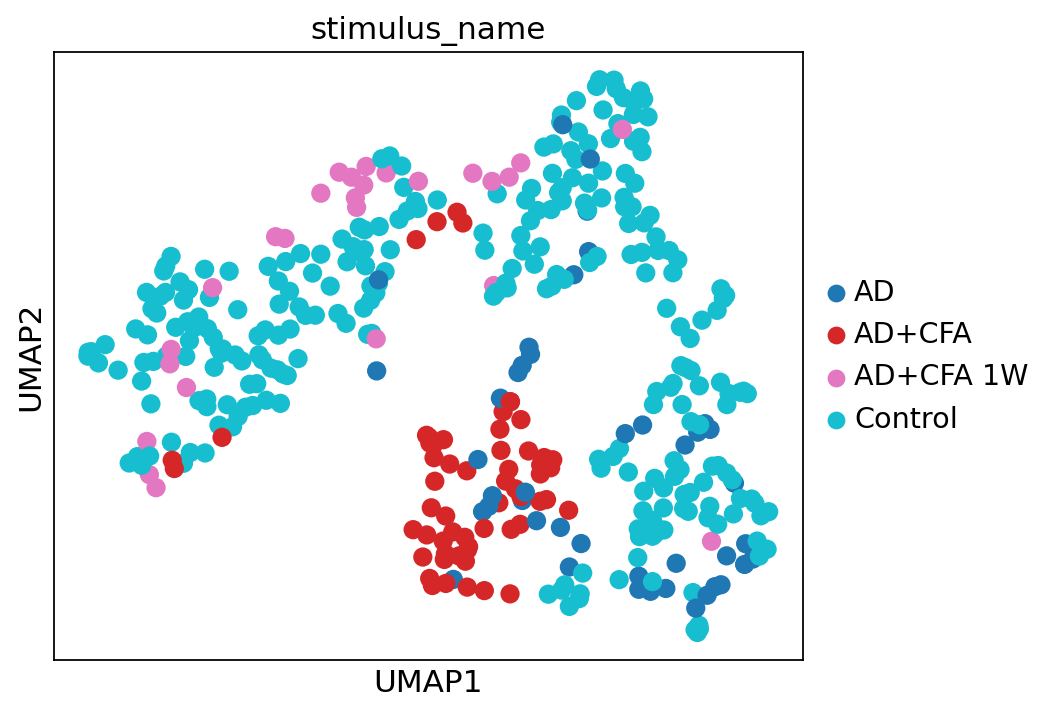

In [46]:
sc.pl.umap(adata_sub, color=['stimulus_name'], groups=['AD','AD+CFA','AD+CFA 1W','Control'], use_raw=False)

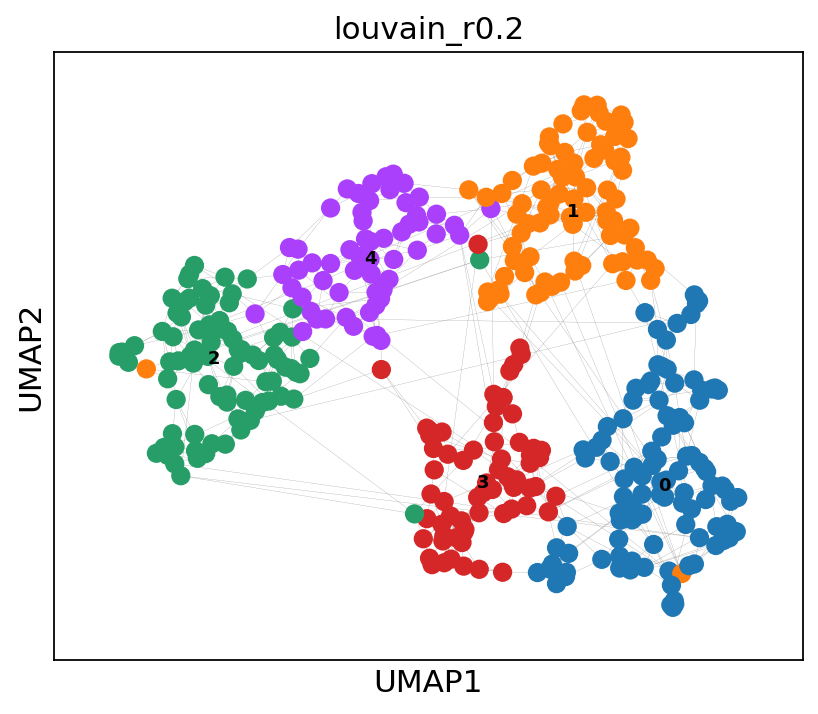

In [47]:
SELECTED_LOUVAIN = 'louvain_r0.2'
sc.pl.umap(adata_sub, edges=True, color = SELECTED_LOUVAIN, legend_loc= 'on data', legend_fontsize= 'xx-small')

drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fr', graph_drawing coordinates (adata.obsm) (0:00:00)


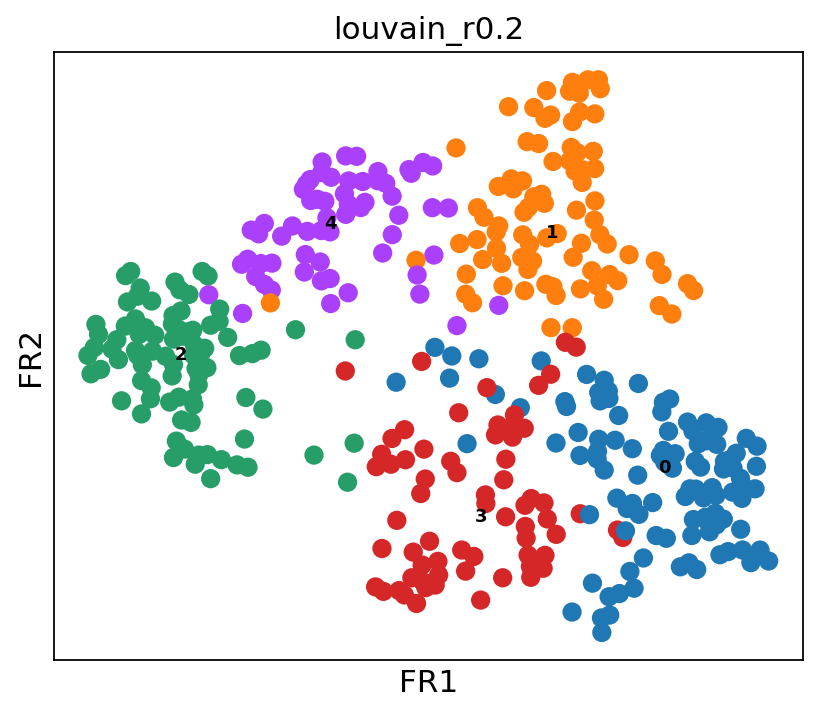

In [48]:
# rerun PAGA
sc.tl.draw_graph(adata_sub, init_pos='X_umap')
sc.pl.draw_graph(adata_sub, color=SELECTED_LOUVAIN, legend_loc='on data', legend_fontsize = 'xx-small')

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])


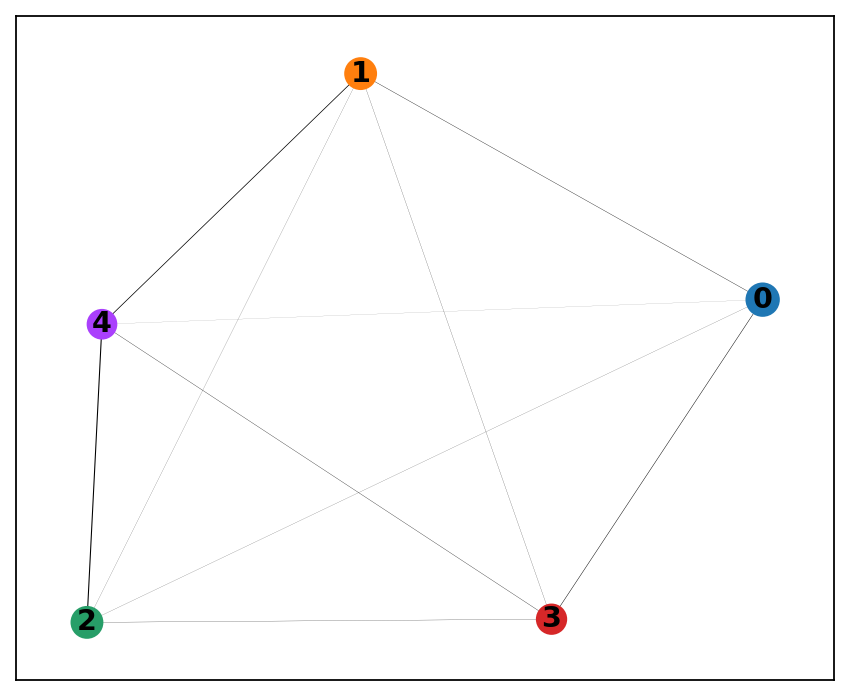

In [49]:
sc.tl.paga(adata_sub, groups=SELECTED_LOUVAIN)
sc.pl.paga(adata_sub, color=SELECTED_LOUVAIN, edge_width_scale = 0.3)

In [50]:
# We can now redraw the graph using another starting position from the paga layout. The following is just as well possible for a UMAP.
sc.tl.draw_graph(adata_sub, init_pos='paga')

drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fr', graph_drawing coordinates (adata.obsm) (0:00:00)


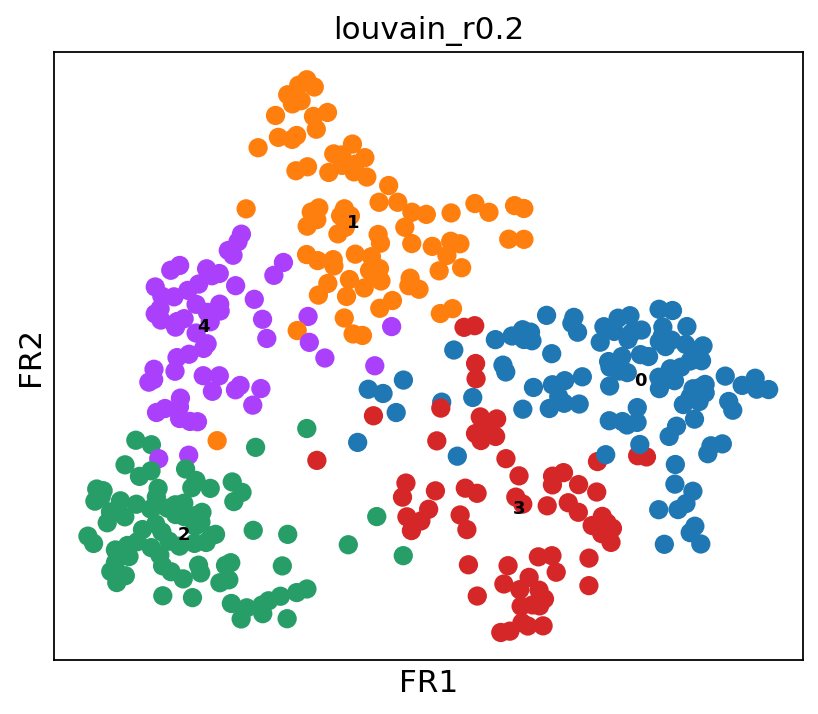

In [51]:
sc.pl.draw_graph(adata_sub, color=[SELECTED_LOUVAIN], legend_loc='on data', legend_fontsize=  'xx-small')

--> added 'pos', the PAGA positions (adata.uns['paga'])


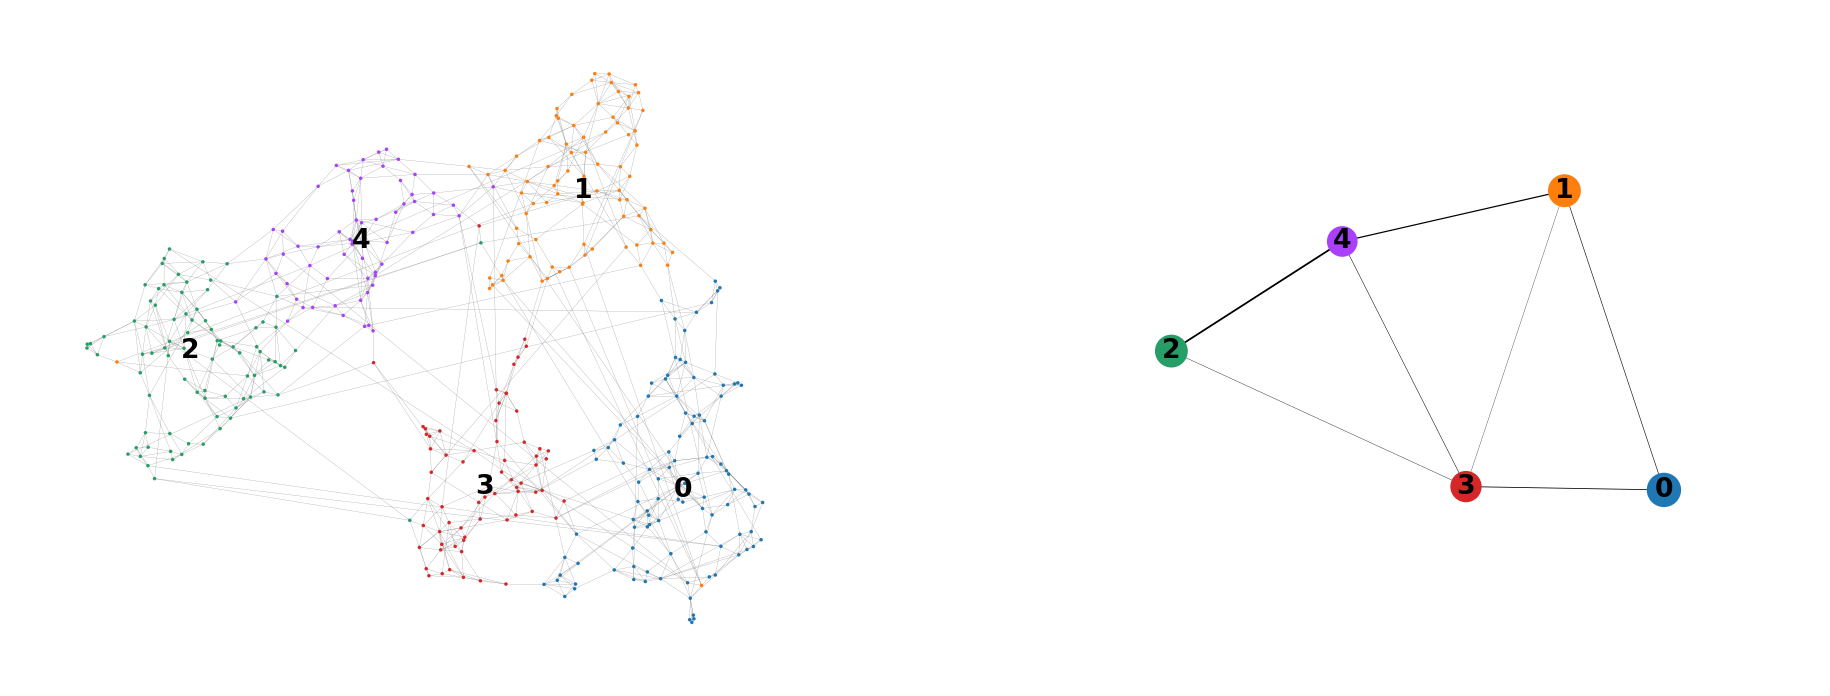

In [52]:
sc.pl.paga_compare(
    adata_sub, threshold=0.03, title='', right_margin=0.2, size=10, edge_width_scale=0.5,
    legend_fontsize=12, fontsize=12, frameon=False, edges=True)

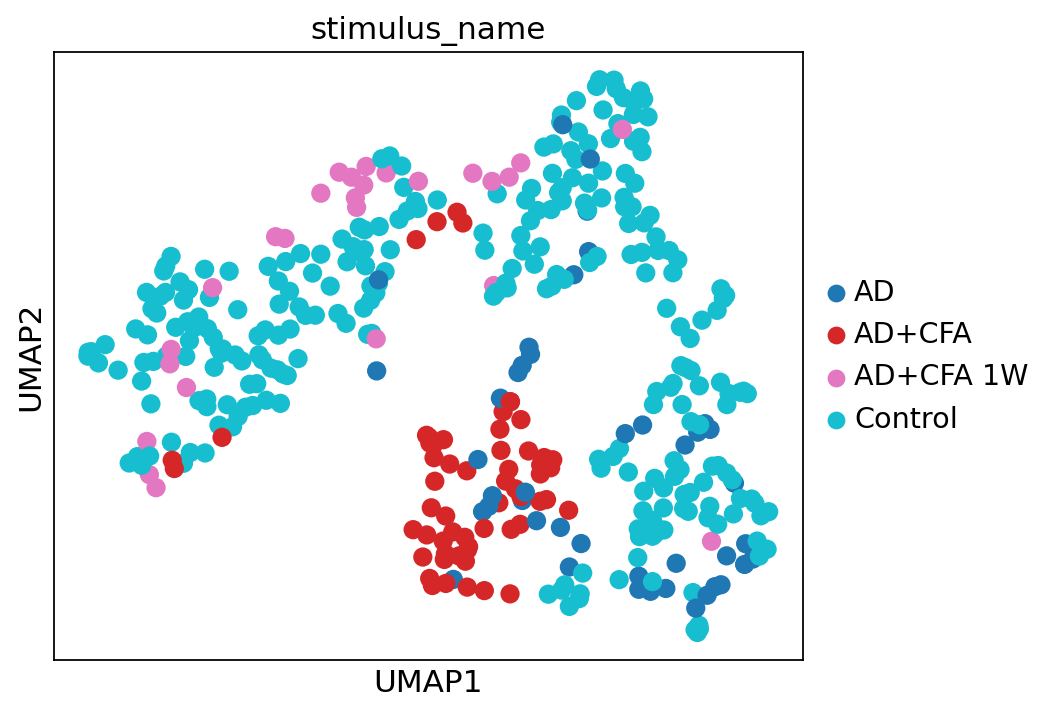

In [53]:
sc.pl.umap(adata_sub, color=['stimulus_name'], groups=['AD','AD+CFA','AD+CFA 1W','Control'], use_raw=False)

In [54]:
# Choose a root cell for diffusion pseudotime. 
# cluster 0 a "root cell" of pseudotime?
adata_sub.uns['iroot'] = np.flatnonzero(adata_sub.obs[SELECTED_LOUVAIN]  == '0')[0]

sc.tl.dpt(adata_sub)

computing Diffusion Pseudotime using n_dcs=10
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)


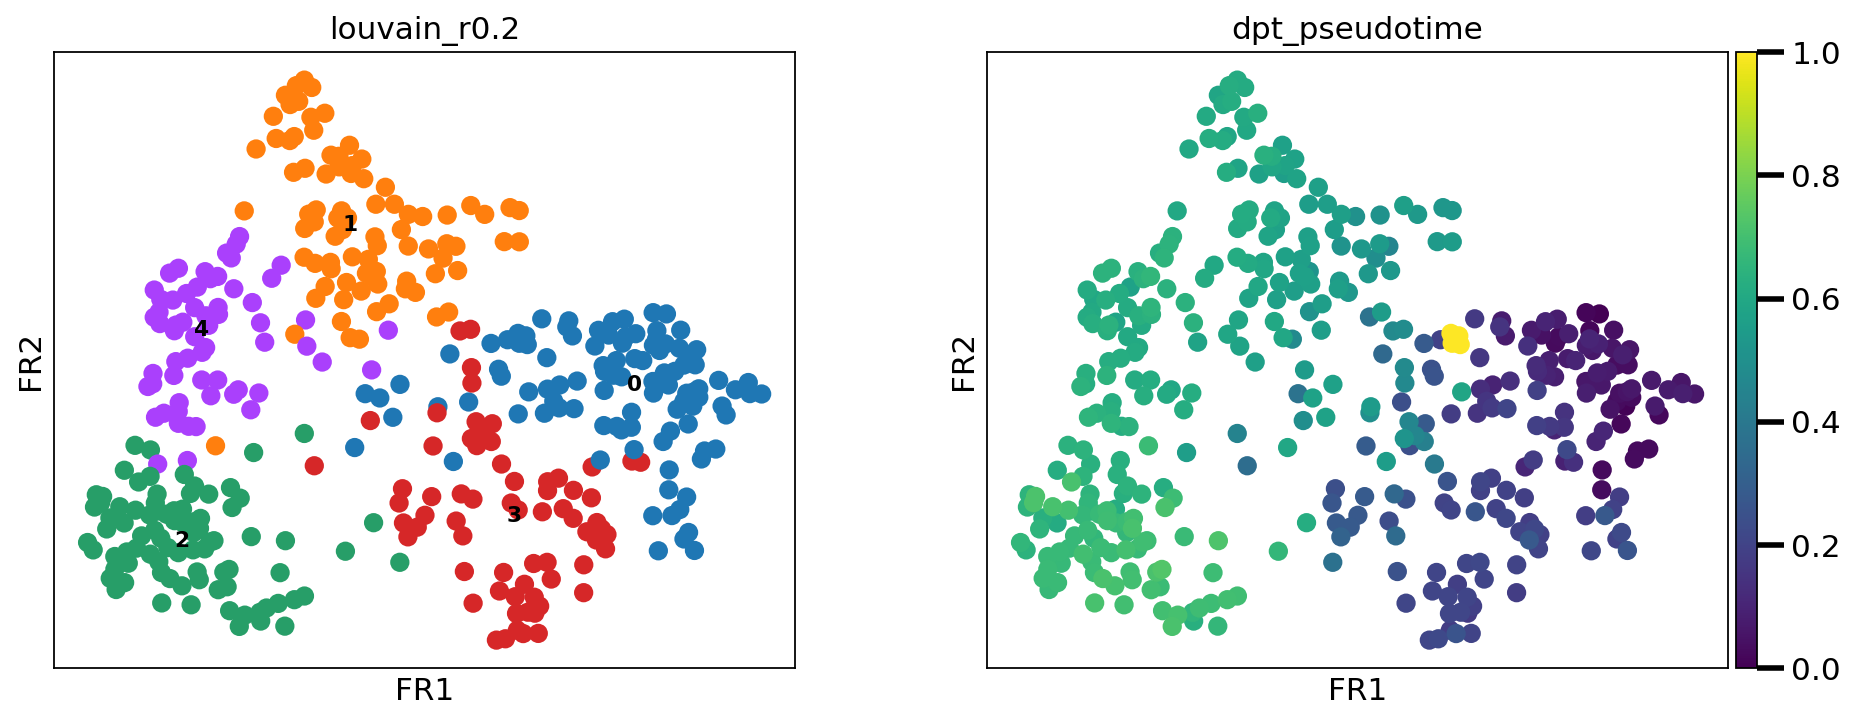

In [55]:
sc.pl.draw_graph(adata_sub, color=[SELECTED_LOUVAIN, 'dpt_pseudotime'], legend_loc='on data', legend_fontsize= 'x-small')

In [56]:
adata_sub

AnnData object with n_obs × n_vars = 399 × 16000
    obs: 'sample', 'stimulus', 'red', 'green', 'well_id', 'plate_number', 'batch', 'stimulus_name', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'n_genes', 'to_exclude', 'plate_str', 'louvain_r0.5', 'louvain_r1', 'louvain_r1.5', 'louvain_r2', 'louvain_r2.5', 'louvain_r0.1', 'louvain_r0.2', 'louvain_r0.3', 'louvain_r0.4', 'louvain_r1.0', 'louvain_r2.0', 'dpt_pseudotime'
    var: 'gene_id', 'gene_name', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'louvain', 'louvain_r1_colors', 'louvain_r2.5_colors', 'louvain_r2_colors', 'neighbors', 'pca', 'plate_str_colors', 'sample_colors', 'stimulus_name_colors', 'umap', 'louvain_r0.1_colors', 'louvain_r0.2_colors', 'louvain_r0.3_colors', 'louvain_r0.4_colors', 'louvain_r1.0_colors', 'louvain_r2.0_colors', 'draw_g

In [57]:
# save umap data
adata_sub.write_h5ad(
    os.path.join(output_path, 'ad_subset.h5ad')
)